### Import Major Libraries

In [1]:
import json
import requests
import pandas as pd
from collections import Counter

## Define Gameweek and Periods for FDR calculation

In [2]:
gameweek = 8
next_n_games = 2

#define percentage of time player needs to have played to be counted as active
min_min = ((gameweek-1)*90)/4     #<---- Currently 25% of playtime
print(min_min)

157.5


## Define Budget, Team Formation, and Budget Allocation by Position

In [3]:
#Budget
budget = 100

#Team Formation
DF = 3
MD = 4
ST = 3

#Total players needed per position
DF_max = 5
MD_max = 5
ST_max = 3

#Budget Allocation
GK_coef = 0.095
DF_coef = 0.285
MD_coef = 0.36
ST_coef = 0.26

print(sum([GK_coef, DF_coef, MD_coef, ST_coef]))

1.0


## Scraped list of Schedules

In [4]:
schedules = ['Arsenal NEW (A) BUR (H) LIV (A) TOT (H) WAT (A) AVL (H) MUN (A) BOU (H) SHU (A) CRY (H) WOL (H) LEI (A) SOU (H) NOR (A) BHA (H) WHU (A) MCI (H) EVE (A) BOU (A) CHE (H) MUN (H) CRY (A) SHU (H) CHE (A) BUR (A) NEW (H) EVE (H) MCI (A) WHU (H) BHA (A) SOU (A) NOR (H) WOL (A) LEI (H) TOT (A) LIV (H) AVL (A) WAT (H)',
 'Aston Villa TOT (A) BOU (H) EVE (H) CRY (A) WHU (H) ARS (A) BUR (H) NOR (A) BHA (H) MCI (A) LIV (H) WOL (A) NEW (H) MUN (A) CHE (A) LEI (H) SHU (A) SOU (H) NOR (H) WAT (A) BUR (A) MCI (H) BHA (A) WAT (H) BOU (A) TOT (H) SOU (A) SHU (H) LEI (A) CHE (H) NEW (A) WOL (H) LIV (A) MUN (H) CRY (H) EVE (A) ARS (H) WHU (A)',
 'Bournemouth SHU (H) AVL (A) MCI (H) LEI (A) EVE (H) SOU (A) WHU (H) ARS (A) NOR (H) WAT (A) MUN (H) NEW (A) WOL (H) TOT (A) CRY (A) LIV (H) CHE (A) BUR (H) ARS (H) BHA (A) WHU (A) WAT (H) NOR (A) BHA (H) AVL (H) SHU (A) BUR (A) CHE (H) LIV (A) CRY (H) WOL (A) NEW (H) MUN (A) TOT (H) LEI (H) MCI (A) SOU (H) EVE (A)',
 'Brighton WAT (A) WHU (H) SOU (H) MCI (A) BUR (H) NEW (A) CHE (A) TOT (H) AVL (A) EVE (H) NOR (H) MUN (A) LEI (H) LIV (A) ARS (A) WOL (H) CRY (A) SHU (H) TOT (A) BOU (H) CHE (H) EVE (A) AVL (H) BOU (A) WHU (A) WAT (H) SHU (A) CRY (H) WOL (A) ARS (H) LEI (A) MUN (H) NOR (A) LIV (H) MCI (H) SOU (A) NEW (H) BUR (A)',
 'Burnley SOU (H) ARS (A) WOL (A) LIV (H) BHA (A) NOR (H) AVL (A) EVE (H) LEI (A) CHE (H) SHU (A) WHU (H) WAT (A) CRY (H) MCI (H) TOT (A) NEW (H) BOU (A) EVE (A) MUN (H) AVL (H) CHE (A) LEI (H) MUN (A) ARS (H) SOU (A) BOU (H) NEW (A) TOT (H) MCI (A) WAT (H) CRY (A) SHU (H) WHU (A) LIV (A) WOL (H) NOR (A) BHA (H)',
 'Chelsea MUN (A) LEI (H) NOR (A) SHU (H) WOL (A) LIV (H) BHA (H) SOU (A) NEW (H) BUR (A) WAT (A) CRY (H) MCI (A) WHU (H) AVL (H) EVE (A) BOU (H) TOT (A) SOU (H) ARS (A) BHA (A) BUR (H) NEW (A) ARS (H) LEI (A) MUN (H) TOT (H) BOU (A) EVE (H) AVL (A) MCI (H) WHU (A) WAT (H) CRY (A) SHU (A) NOR (H) LIV (A) WOL (H)',
 'Crystal Palace EVE (H) SHU (A) MUN (A) AVL (H) TOT (A) WOL (H) NOR (H) WHU (A) MCI (H) ARS (A) LEI (H) CHE (A) LIV (H) BUR (A) BOU (H) WAT (A) BHA (H) NEW (A) WHU (H) SOU (A) NOR (A) ARS (H) MCI (A) SOU (H) SHU (H) EVE (A) NEW (H) BHA (A) WAT (H) BOU (A) LIV (A) BUR (H) LEI (A) CHE (H) AVL (A) MUN (H) WOL (A) TOT (H)',
 'Everton CRY (A) WAT (H) AVL (A) WOL (H) BOU (A) SHU (H) MCI (H) BUR (A) WHU (H) BHA (A) TOT (H) SOU (A) NOR (H) LEI (A) LIV (A) CHE (H) MUN (A) ARS (H) BUR (H) NEW (A) MCI (A) BHA (H) WHU (A) NEW (H) WAT (A) CRY (H) ARS (A) MUN (H) CHE (A) LIV (H) NOR (A) LEI (H) TOT (A) SOU (H) WOL (A) AVL (H) SHU (A) BOU (H)',
 'Leicester WOL (H) CHE (A) SHU (A) BOU (H) MUN (A) TOT (H) NEW (H) LIV (A) BUR (H) SOU (A) CRY (A) ARS (H) BHA (A) EVE (H) WAT (H) AVL (A) NOR (H) MCI (A) LIV (H) WHU (A) NEW (A) SOU (H) BUR (A) WHU (H) CHE (H) WOL (A) MCI (H) NOR (A) AVL (H) WAT (A) BHA (H) EVE (A) CRY (H) ARS (A) BOU (A) SHU (H) TOT (A) MUN (H)',
 'Liverpool NOR (H) SOU (A) ARS (H) BUR (A) NEW (H) CHE (A) SHU (A) LEI (H) MUN (A) TOT (H) AVL (A) MCI (H) CRY (A) BHA (H) EVE (H) BOU (A) WAT (H) WHU (A) LEI (A) WOL (H) SHU (H) TOT (A) MUN (H) WOL (A) SOU (H) NOR (A) WHU (H) WAT (A) BOU (H) EVE (A) CRY (H) MCI (A) AVL (H) BHA (A) BUR (H) ARS (A) CHE (H) NEW (A)',
 'Man City WHU (A) TOT (H) BOU (A) BHA (H) NOR (A) WAT (H) EVE (A) WOL (H) CRY (A) AVL (H) SOU (H) LIV (A) CHE (H) NEW (A) BUR (A) MUN (H) ARS (A) LEI (H) WOL (A) SHU (H) EVE (H) AVL (A) CRY (H) SHU (A) TOT (A) WHU (H) LEI (A) ARS (H) MUN (A) BUR (H) CHE (A) LIV (H) SOU (A) NEW (H) BHA (A) BOU (H) WAT (A) NOR (H)',
 'Man Utd CHE (H) WOL (A) CRY (H) SOU (A) LEI (H) WHU (A) ARS (H) NEW (A) LIV (H) NOR (A) BOU (A) BHA (H) SHU (A) AVL (H) TOT (H) MCI (A) EVE (H) WAT (A) NEW (H) BUR (A) ARS (A) NOR (H) LIV (A) BUR (H) WOL (H) CHE (A) WAT (H) EVE (A) MCI (H) TOT (A) SHU (H) BHA (A) BOU (H) AVL (A) SOU (H) CRY (A) WHU (H) LEI (A)',
 'Newcastle ARS (H) NOR (A) TOT (A) WAT (H) LIV (A) BHA (H) LEI (A) MUN (H) CHE (A) WOL (H) WHU (A) BOU (H) AVL (A) MCI (H) SHU (A) SOU (H) BUR (A) CRY (H) MUN (A) EVE (H) LEI (H) WOL (A) CHE (H) EVE (A) NOR (H) ARS (A) CRY (A) BUR (H) SOU (A) SHU (H) AVL (H) BOU (A) WHU (H) MCI (A) WAT (A) TOT (H) BHA (A) LIV (H)',
 'Norwich LIV (A) NEW (H) CHE (H) WHU (A) MCI (H) BUR (A) CRY (A) AVL (H) BOU (A) MUN (H) BHA (A) WAT (H) EVE (A) ARS (H) SOU (A) SHU (H) LEI (A) WOL (H) AVL (A) TOT (H) CRY (H) MUN (A) BOU (H) TOT (A) NEW (A) LIV (H) WOL (A) LEI (H) SHU (A) SOU (H) EVE (H) ARS (A) BHA (H) WAT (A) WHU (H) CHE (A) BUR (H) MCI (A)',
 'Sheffield Utd BOU (A) CRY (H) LEI (H) CHE (A) SOU (H) EVE (A) LIV (H) WAT (A) ARS (H) WHU (A) BUR (H) TOT (A) MUN (H) WOL (A) NEW (H) NOR (A) AVL (H) BHA (A) WAT (H) MCI (A) LIV (A) WHU (H) ARS (A) MCI (H) CRY (A) BOU (H) BHA (H) AVL (A) NOR (H) NEW (A) MUN (A) TOT (H) BUR (A) WOL (H) CHE (H) LEI (A) EVE (H) SOU (A)',
 'Southampton BUR (A) LIV (H) BHA (A) MUN (H) SHU (A) BOU (H) TOT (A) CHE (H) WOL (A) LEI (H) MCI (A) EVE (H) ARS (A) WAT (H) NOR (H) NEW (A) WHU (H) AVL (A) CHE (A) CRY (H) TOT (H) LEI (A) WOL (H) CRY (A) LIV (A) BUR (H) AVL (H) WHU (A) NEW (H) NOR (A) ARS (H) WAT (A) MCI (H) EVE (A) MUN (A) BHA (H) BOU (A) SHU (H)',
 'Spurs AVL (H) MCI (A) NEW (H) ARS (A) CRY (H) LEI (A) SOU (H) BHA (A) WAT (H) LIV (A) EVE (A) SHU (H) WHU (A) BOU (H) MUN (A) BUR (H) WOL (A) CHE (H) BHA (H) NOR (A) SOU (A) LIV (H) WAT (A) NOR (H) MCI (H) AVL (A) CHE (A) WOL (H) BUR (A) MUN (H) WHU (H) SHU (A) EVE (H) BOU (A) ARS (H) NEW (A) LEI (H) CRY (A)',
 'Watford BHA (H) EVE (A) WHU (H) NEW (A) ARS (H) MCI (A) WOL (A) SHU (H) TOT (A) BOU (H) CHE (H) NOR (A) BUR (H) SOU (A) LEI (A) CRY (H) LIV (A) MUN (H) SHU (A) AVL (H) WOL (H) BOU (A) TOT (H) AVL (A) EVE (H) BHA (A) MUN (A) LIV (H) CRY (A) LEI (H) BUR (A) SOU (H) CHE (A) NOR (H) NEW (H) WHU (A) MCI (H) ARS (A)',
 'West Ham MCI (H) BHA (A) WAT (A) NOR (H) AVL (A) MUN (H) BOU (A) CRY (H) EVE (A) SHU (H) NEW (H) BUR (A) TOT (H) CHE (A) WOL (A) ARS (H) SOU (A) LIV (H) CRY (A) LEI (H) BOU (H) SHU (A) EVE (H) LEI (A) BHA (H) MCI (A) LIV (A) SOU (H) ARS (A) WOL (H) TOT (A) CHE (H) NEW (A) BUR (H) NOR (A) WAT (H) MUN (A) AVL (H)',
 'Wolves LEI (A) MUN (H) BUR (H) EVE (A) CHE (H) CRY (A) WAT (H) MCI (A) SOU (H) NEW (A) ARS (A) AVL (H) BOU (A) SHU (H) WHU (H) BHA (A) TOT (H) NOR (A) MCI (H) LIV (A) WAT (A) NEW (H) SOU (A) LIV (H) MUN (A) LEI (H) NOR (H) TOT (A) BHA (H) WHU (A) BOU (H) AVL (A) ARS (H) SHU (A) EVE (H) BUR (A) CRY (H) CHE (A)']

### Import Data

In [5]:


# url = "https://fantasy.premierleague.com/drf/bootstrap-static"
url = 'https://fantasy.premierleague.com/api/bootstrap-static/'

def get_json_data(url):
    response = requests.get(url)
    jobs = response.json()
    return jobs

#filter out players with less than 330
all_players = get_json_data(url)['elements']
all_teams = get_json_data(url)['teams']
positions = get_json_data(url)['element_types']

### Get Team Table

In [6]:
table_url = 'https://www.premierleague.com/tables'

def build_table(table_url):
    team_table = pd.read_html(table_url)
    team_df = pd.DataFrame(team_table[0])
    team_df = team_df[team_df['Unnamed: 12'].isna()]
    team_df = team_df.iloc[:,1:10]
    team_df.Club = team_df.Club.map(lambda x: x[-3:])
    team_df.reset_index()
    team_df.index = np.arange(1, len(team_df) + 1)
    team_df.columns = ['Team', 'Played', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts']
    team_df.index.name = 'Position'
    
    return team_df

In [7]:
table_df = build_table(table_url)

In [8]:
table_df.head()

,Team,Played,W,D,L,GF,GA,GD,Pts
Position,,,,,,,,,
1,LIV,7,7,0,0,18,5,+13,21
2,MCI,7,5,1,1,27,7,+20,16
3,LEI,7,4,2,1,13,5,+8,14
4,ARS,7,3,3,1,12,11,+1,12
5,WHU,7,3,3,1,10,9,+1,12


## Add player status and ROI, pts-per-90min metrics to final player_df

In [9]:
def attach_team_and_position(main_players, all_teams, positons):
    players = main_players.copy()
    for team in all_teams:
        for player in players:
            if team['code'] == player['team_code']:
                player['team_name'] = team['name']
    for position in positions:
        for player in players:
            if position['id'] == player['element_type']:
                player['position'] = position['singular_name']
    for player in players:
        if player['status'] == "a":
            player['status'] = "available"
        elif player['status'] == "d":
            player['status'] = "doubtful"
        elif player['status'] == "i":
            player['status'] = "injured"
        elif player['status'] == "s":
            player['status'] = "suspended"
    return players


#### Temporarily took out the "main_players" filter because no players have played 330 minutes ####

# player_positions_teams = attach_team_and_position(main_players, all_teams_new, positions)
player_positions_teams = attach_team_and_position(all_players, all_teams, positions)


def final_players_list(player_positions_teams):
    players = player_positions_teams.copy()
    empty = []
    for player in players:
        stats = dict(team_code = player['team_code'],
        team_name = player['team_name'],
        name = player['first_name'] + " " + player['second_name'],
        status = player['status'],
        position = player['position'],
        cost = (player['now_cost'])/10,
        total_points = player['total_points'],
        roi = round((player['total_points'] / player['now_cost'])*10, 2),
        pts_per_90min = round((player['total_points'] / (player['minutes'] + 1))*90, 2),
        bonus = player['bonus'],
        red_cards = player['red_cards'],
        minutes = player['minutes'],
        transfers_out = player['transfers_out'],
        transfers_in = player['transfers_in'])
        empty.append(stats)
    return empty

In [10]:
final = final_players_list(player_positions_teams)

In [11]:
final[0]

{'team_code': 3,
 'team_name': 'Arsenal',
 'name': 'Shkodran Mustafi',
 'status': 'available',
 'position': 'Defender',
 'cost': 5.3,
 'total_points': 0,
 'roi': 0.0,
 'pts_per_90min': 0.0,
 'bonus': 0,
 'red_cards': 0,
 'minutes': 0,
 'transfers_out': 26260,
 'transfers_in': 5348}

In [12]:
all_teams[0]

{'code': 3,
 'draw': 0,
 'form': None,
 'id': 1,
 'loss': 0,
 'name': 'Arsenal',
 'played': 0,
 'points': 0,
 'position': 0,
 'short_name': 'ARS',
 'strength': 4,
 'team_division': None,
 'unavailable': False,
 'win': 0,
 'strength_overall_home': 1250,
 'strength_overall_away': 1330,
 'strength_attack_home': 1210,
 'strength_attack_away': 1260,
 'strength_defence_home': 1290,
 'strength_defence_away': 1330}

### Get Total ROI, Points and 90min before filtering injured and FDR

In [13]:
total_roi = sorted(final, key = lambda x: x['roi'], reverse = True)

In [14]:
total_roi[:2]

[{'team_code': 49,
  'team_name': 'Sheffield Utd',
  'name': 'John Lundstram',
  'status': 'available',
  'position': 'Defender',
  'cost': 4.5,
  'total_points': 34,
  'roi': 7.56,
  'pts_per_90min': 5.11,
  'bonus': 7,
  'red_cards': 0,
  'minutes': 598,
  'transfers_out': 207497,
  'transfers_in': 1629228},
 {'team_code': 45,
  'team_name': 'Norwich',
  'name': 'Teemu Pukki',
  'status': 'available',
  'position': 'Forward',
  'cost': 7.2,
  'total_points': 53,
  'roi': 7.36,
  'pts_per_90min': 7.66,
  'bonus': 9,
  'red_cards': 0,
  'minutes': 622,
  'transfers_out': 619237,
  'transfers_in': 3116428}]

### Total_Points

In [15]:
total_max_pts = sorted(total_roi, key = lambda x: x['total_points'], reverse = True)

In [16]:
total_max_pts[:2]

[{'team_code': 43,
  'team_name': 'Man City',
  'name': 'Kevin De Bruyne',
  'status': 'injured',
  'position': 'Midfielder',
  'cost': 10.0,
  'total_points': 63,
  'roi': 6.3,
  'pts_per_90min': 10.72,
  'bonus': 10,
  'red_cards': 0,
  'minutes': 528,
  'transfers_out': 715313,
  'transfers_in': 2090266},
 {'team_code': 43,
  'team_name': 'Man City',
  'name': 'Sergio Agüero',
  'status': 'available',
  'position': 'Forward',
  'cost': 12.2,
  'total_points': 59,
  'roi': 4.84,
  'pts_per_90min': 11.27,
  'bonus': 6,
  'red_cards': 0,
  'minutes': 470,
  'transfers_out': 444031,
  'transfers_in': 1124582}]

### 90 min

In [17]:
total_90min = sorted(total_roi, key = lambda x: x['pts_per_90min'], reverse = True)

#define filter of minimum time played
min_min = min_min
total_90min = [player for player in total_90min if player['minutes'] >= min_min]

In [18]:
total_90min[:2]

[{'team_code': 43,
  'team_name': 'Man City',
  'name': 'Sergio Agüero',
  'status': 'available',
  'position': 'Forward',
  'cost': 12.2,
  'total_points': 59,
  'roi': 4.84,
  'pts_per_90min': 11.27,
  'bonus': 6,
  'red_cards': 0,
  'minutes': 470,
  'transfers_out': 444031,
  'transfers_in': 1124582},
 {'team_code': 43,
  'team_name': 'Man City',
  'name': 'Kevin De Bruyne',
  'status': 'injured',
  'position': 'Midfielder',
  'cost': 10.0,
  'total_points': 63,
  'roi': 6.3,
  'pts_per_90min': 10.72,
  'bonus': 10,
  'red_cards': 0,
  'minutes': 528,
  'transfers_out': 715313,
  'transfers_in': 2090266}]

### Create Players DataFrame

In [19]:
player_df = pd.DataFrame(final)

In [20]:
player_df.sort_values(by = ['roi'], ascending = False, inplace = True)

In [21]:
player_df.head(10)

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
386,7,4.5,598,John Lundstram,Defender,5.11,0,7.56,available,49,Sheffield Utd,34,1629228,207497
359,9,7.2,622,Teemu Pukki,Forward,7.66,0,7.36,available,45,Norwich,53,3116428,619237
137,5,4.8,630,Erik Pieters,Defender,4.71,0,6.88,available,90,Burnley,33,897131,223716
171,5,4.6,630,Joel Ward,Defender,4.42,0,6.74,available,31,Crystal Palace,31,232105,62447
39,4,5.8,630,John McGinn,Midfielder,5.42,0,6.55,available,7,Aston Villa,38,775461,276679
217,5,6.1,630,Ricardo Domingos Barbosa Pereira,Defender,5.56,0,6.39,available,13,Leicester,39,293522,165470
280,10,10.0,528,Kevin De Bruyne,Midfielder,10.72,0,6.30,injured,43,Man City,63,2090266,715313
507,4,5.1,573,Lukasz Fabianski,Goalkeeper,5.02,0,6.27,injured,21,West Ham,32,230287,213119
533,4,5.1,630,Rui Pedro dos Santos Patrício,Goalkeeper,4.56,0,6.27,available,39,Wolves,32,411918,209793
368,2,5.0,606,Todd Cantwell,Midfielder,4.60,0,6.20,doubtful,45,Norwich,31,2059426,365064


### Merge two team tables s owe have all data

In [22]:
def merged_teams(table_df, all_teams):
    table_dic = table_df.to_dict('records')
    
    for team in table_dic:
        for item in all_teams:
            if team['Team'] == item['short_name']:
                team['code'] = item['code']
                team['name'] = item['name']
                team['strength'] = item['strength']
            
    new_df = pd.DataFrame(table_dic)
    
    new_order = ['code', 'strength', 'Team','name', 'Played', 'W', 'L', 'D', 'GF', 'GA', 'GD', 'Pts']
    
    table_df = new_df[new_order]
    
    table_df.index = np.arange(1, len(table_df) + 1)
    table_df.index.name = 'Position'
    
    return table_df
    

In [23]:
team_df = merged_teams(table_df, all_teams)

In [24]:
team_df.head()

,code,strength,Team,name,Played,W,L,D,GF,GA,GD,Pts
Position,,,,,,,,,,,,
1,14,5,LIV,Liverpool,7,7,0,0,18,5,+13,21
2,43,5,MCI,Man City,7,5,1,1,27,7,+20,16
3,13,3,LEI,Leicester,7,4,1,2,13,5,+8,14
4,3,4,ARS,Arsenal,7,3,1,3,12,11,+1,12
5,21,3,WHU,West Ham,7,3,1,3,10,9,+1,12


In [25]:
team_names = list(team_df.name)

In [26]:
team_names.sort()

In [27]:
team_names

['Arsenal',
 'Aston Villa',
 'Bournemouth',
 'Brighton',
 'Burnley',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Leicester',
 'Liverpool',
 'Man City',
 'Man Utd',
 'Newcastle',
 'Norwich',
 'Sheffield Utd',
 'Southampton',
 'Spurs',
 'Watford',
 'West Ham',
 'Wolves']

## Create Schedule DF

In [28]:
def extract_sched(schedules):
    dic = {}
    for i, item in enumerate(schedules):
        name = item.partition(team_names[i])[1]
        sche = item.partition(team_names[i])[2]
        sche = sche.split()
        clean = [item for item in sche if item != "(A)"]
        clean2 = [item for item in clean if item != "(H)"]
        dic[name] = clean2
    return dic

In [29]:
wonders = extract_sched(schedules)

In [30]:
schedule_df = pd.DataFrame(wonders)

In [31]:
schedule_df.index.name = 'Gameweek'

In [32]:
schedule_df.head()

,Arsenal,Aston Villa,Bournemouth,Brighton,Burnley,Chelsea,Crystal Palace,Everton,Leicester,Liverpool,Man City,Man Utd,Newcastle,Norwich,Sheffield Utd,Southampton,Spurs,Watford,West Ham,Wolves
Gameweek,,,,,,,,,,,,,,,,,,,,
0,NEW,TOT,SHU,WAT,SOU,MUN,EVE,CRY,WOL,NOR,WHU,CHE,ARS,LIV,BOU,BUR,AVL,BHA,MCI,LEI
1,BUR,BOU,AVL,WHU,ARS,LEI,SHU,WAT,CHE,SOU,TOT,WOL,NOR,NEW,CRY,LIV,MCI,EVE,BHA,MUN
2,LIV,EVE,MCI,SOU,WOL,NOR,MUN,AVL,SHU,ARS,BOU,CRY,TOT,CHE,LEI,BHA,NEW,WHU,WAT,BUR
3,TOT,CRY,LEI,MCI,LIV,SHU,AVL,WOL,BOU,BUR,BHA,SOU,WAT,WHU,CHE,MUN,ARS,NEW,NOR,EVE
4,WAT,WHU,EVE,BUR,BHA,WOL,TOT,BOU,MUN,NEW,NOR,LEI,LIV,MCI,SOU,SHU,CRY,ARS,AVL,CHE


In [33]:
schedule_df.Arsenal[0:3]

Gameweek
0    NEW
1    BUR
2    LIV
Name: Arsenal, dtype: object

## Create FDR scores for calculating next-n opponents AVG strength

In [34]:
scores = list(zip(team_df.Team, team_df.strength))

In [35]:
scores = dict(scores)

In [36]:
sorted(scores.items(), key = lambda x: x[1], reverse = True)

[('LIV', 5),
 ('MCI', 5),
 ('ARS', 4),
 ('TOT', 4),
 ('CHE', 4),
 ('MUN', 4),
 ('LEI', 3),
 ('WHU', 3),
 ('BOU', 3),
 ('CRY', 3),
 ('BUR', 3),
 ('WOL', 3),
 ('SOU', 3),
 ('EVE', 3),
 ('NOR', 3),
 ('NEW', 3),
 ('SHU', 2),
 ('BHA', 2),
 ('AVL', 2),
 ('WAT', 2)]

No handles with labels found to put in legend.


<function matplotlib.pyplot.show(*args, **kw)>

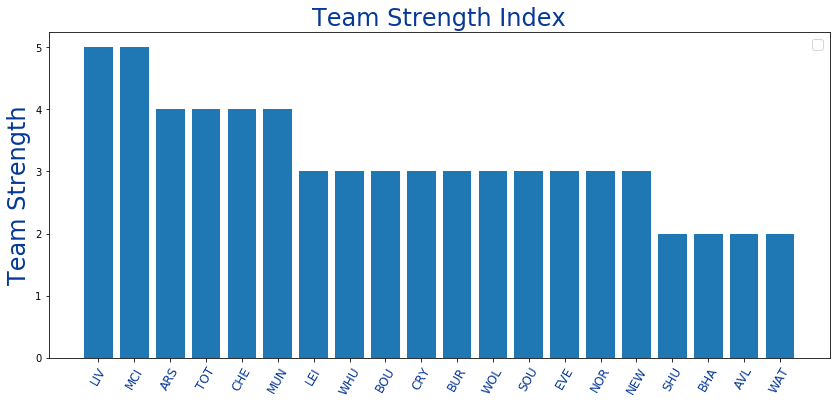

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6

sorted_data = sorted(scores.items(), key = lambda x: x[1], reverse = True)

Team = [item[0] for item in sorted_data]
strength = [item[1] for item in sorted_data]

plt.bar(Team, strength)
plt.ylabel('Team Strength', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Team Strength Index', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

In [38]:
schedule_df.columns

Index(['Arsenal', 'Aston Villa', 'Bournemouth', 'Brighton', 'Burnley',
       'Chelsea', 'Crystal Palace', 'Everton', 'Leicester', 'Liverpool',
       'Man City', 'Man Utd', 'Newcastle', 'Norwich', 'Sheffield Utd',
       'Southampton', 'Spurs', 'Watford', 'West Ham', 'Wolves'],
      dtype='object')

In [39]:
schedule_df.head(10)

,Arsenal,Aston Villa,Bournemouth,Brighton,Burnley,Chelsea,Crystal Palace,Everton,Leicester,Liverpool,Man City,Man Utd,Newcastle,Norwich,Sheffield Utd,Southampton,Spurs,Watford,West Ham,Wolves
Gameweek,,,,,,,,,,,,,,,,,,,,
0,NEW,TOT,SHU,WAT,SOU,MUN,EVE,CRY,WOL,NOR,WHU,CHE,ARS,LIV,BOU,BUR,AVL,BHA,MCI,LEI
1,BUR,BOU,AVL,WHU,ARS,LEI,SHU,WAT,CHE,SOU,TOT,WOL,NOR,NEW,CRY,LIV,MCI,EVE,BHA,MUN
2,LIV,EVE,MCI,SOU,WOL,NOR,MUN,AVL,SHU,ARS,BOU,CRY,TOT,CHE,LEI,BHA,NEW,WHU,WAT,BUR
3,TOT,CRY,LEI,MCI,LIV,SHU,AVL,WOL,BOU,BUR,BHA,SOU,WAT,WHU,CHE,MUN,ARS,NEW,NOR,EVE
4,WAT,WHU,EVE,BUR,BHA,WOL,TOT,BOU,MUN,NEW,NOR,LEI,LIV,MCI,SOU,SHU,CRY,ARS,AVL,CHE
5,AVL,ARS,SOU,NEW,NOR,LIV,WOL,SHU,TOT,CHE,WAT,WHU,BHA,BUR,EVE,BOU,LEI,MCI,MUN,CRY
6,MUN,BUR,WHU,CHE,AVL,BHA,NOR,MCI,NEW,SHU,EVE,ARS,LEI,CRY,LIV,TOT,SOU,WOL,BOU,WAT
7,BOU,NOR,ARS,TOT,EVE,SOU,WHU,BUR,LIV,LEI,WOL,NEW,MUN,AVL,WAT,CHE,BHA,SHU,CRY,MCI
8,SHU,BHA,NOR,AVL,LEI,NEW,MCI,WHU,BUR,MUN,CRY,LIV,CHE,BOU,ARS,WOL,WAT,TOT,EVE,SOU


In [40]:
def avg_FDR(week = gameweek, periods = next_n_games):
    dic = {}
    for team in schedule_df.columns:
        oponents = schedule_df[team][(week-1):(week+periods)]
        avg_FDR = round(sum([scores[oponent] for oponent in oponents])/len(oponents), 2)
        dic[team] = avg_FDR
    return dic

In [41]:
calculate_FDR = avg_FDR()

In [42]:
sorted_FDR = sorted(calculate_FDR.items(), key=lambda x: x[1], reverse=True)

In [43]:
sorted_FDR

[('Crystal Palace', 4.0),
 ('Leicester', 3.67),
 ('Liverpool', 3.67),
 ('Man Utd', 3.67),
 ('Newcastle', 3.67),
 ('Wolves', 3.67),
 ('Aston Villa', 3.33),
 ('Burnley', 3.33),
 ('Southampton', 3.33),
 ('Bournemouth', 3.0),
 ('Brighton', 3.0),
 ('Chelsea', 3.0),
 ('Norwich', 3.0),
 ('Sheffield Utd', 3.0),
 ('Spurs', 3.0),
 ('Watford', 3.0),
 ('Arsenal', 2.67),
 ('Everton', 2.67),
 ('Man City', 2.67),
 ('West Ham', 2.67)]

<function matplotlib.pyplot.show(*args, **kw)>

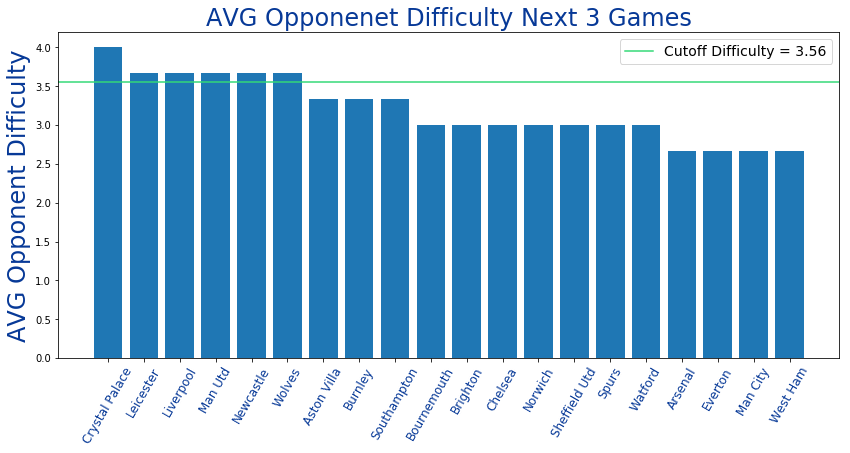

In [44]:
rcParams['figure.figsize'] = 14, 6

Team = [item[0] for item in sorted_FDR]
FDR = [item[1] for item in sorted_FDR]
cutoff = 3.56

plt.bar(Team, FDR)
plt.axhline(y=cutoff, linestyle='-', color='#33D977', label='Cutoff Difficulty = ' + str(cutoff))
plt.ylabel('AVG Opponent Difficulty', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('AVG Opponenet Difficulty Next ' + str(next_n_games +1) + ' Games', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

## Clean final list of available players by FDR score <= 3.56 and status = 'available'

In [45]:
player_df.head()

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
386,7,4.5,598,John Lundstram,Defender,5.11,0,7.56,available,49,Sheffield Utd,34,1629228,207497
359,9,7.2,622,Teemu Pukki,Forward,7.66,0,7.36,available,45,Norwich,53,3116428,619237
137,5,4.8,630,Erik Pieters,Defender,4.71,0,6.88,available,90,Burnley,33,897131,223716
171,5,4.6,630,Joel Ward,Defender,4.42,0,6.74,available,31,Crystal Palace,31,232105,62447
39,4,5.8,630,John McGinn,Midfielder,5.42,0,6.55,available,7,Aston Villa,38,775461,276679


In [46]:
player_df.shape

(546, 14)

In [47]:
clean_df = player_df[player_df.status == 'available']

In [48]:
clean_df.status.value_counts()

available    423
Name: status, dtype: int64

## Remove teams with FDR scores > 3.56 from DF - optional

In [49]:
teams_low_FDR = [key for (key,value) in calculate_FDR.items() if value <= 3.56]

In [50]:
teams_low_FDR

['Arsenal',
 'Aston Villa',
 'Bournemouth',
 'Brighton',
 'Burnley',
 'Chelsea',
 'Everton',
 'Man City',
 'Norwich',
 'Sheffield Utd',
 'Southampton',
 'Spurs',
 'Watford',
 'West Ham']

In [51]:
clean_df.head()

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
386,7,4.5,598,John Lundstram,Defender,5.11,0,7.56,available,49,Sheffield Utd,34,1629228,207497
359,9,7.2,622,Teemu Pukki,Forward,7.66,0,7.36,available,45,Norwich,53,3116428,619237
137,5,4.8,630,Erik Pieters,Defender,4.71,0,6.88,available,90,Burnley,33,897131,223716
171,5,4.6,630,Joel Ward,Defender,4.42,0,6.74,available,31,Crystal Palace,31,232105,62447
39,4,5.8,630,John McGinn,Midfielder,5.42,0,6.55,available,7,Aston Villa,38,775461,276679


In [52]:
final_df = clean_df.loc[clean_df.team_name.isin(teams_low_FDR)]

In [53]:
final_df.head(15)

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
386,7,4.5,598,John Lundstram,Defender,5.11,0,7.56,available,49,Sheffield Utd,34,1629228,207497
359,9,7.2,622,Teemu Pukki,Forward,7.66,0,7.36,available,45,Norwich,53,3116428,619237
137,5,4.8,630,Erik Pieters,Defender,4.71,0,6.88,available,90,Burnley,33,897131,223716
39,4,5.8,630,John McGinn,Midfielder,5.42,0,6.55,available,7,Aston Villa,38,775461,276679
96,6,4.6,630,Mathew Ryan,Goalkeeper,3.99,0,6.09,available,36,Brighton,28,353221,329558
160,9,7.6,486,Tammy Abraham,Forward,8.50,0,6.05,available,8,Chelsea,46,2646599,335623
399,2,4.5,630,Dean Henderson,Goalkeeper,3.85,0,6.00,available,49,Sheffield Utd,27,136789,51456
163,6,6.7,630,Mason Mount,Midfielder,5.56,0,5.82,available,8,Chelsea,39,2452608,557064
66,4,7.9,607,Callum Wilson,Forward,6.81,0,5.82,available,91,Bournemouth,46,387095,750914
419,3,4.5,630,Angus Gunn,Goalkeeper,3.71,0,5.78,available,20,Southampton,26,225752,69623


In [54]:
clean_players = final_df.to_dict('records')

In [55]:
clean_players[:2]

[{'bonus': 7,
  'cost': 4.5,
  'minutes': 598,
  'name': 'John Lundstram',
  'position': 'Defender',
  'pts_per_90min': 5.11,
  'red_cards': 0,
  'roi': 7.56,
  'status': 'available',
  'team_code': 49,
  'team_name': 'Sheffield Utd',
  'total_points': 34,
  'transfers_in': 1629228,
  'transfers_out': 207497},
 {'bonus': 9,
  'cost': 7.2,
  'minutes': 622,
  'name': 'Teemu Pukki',
  'position': 'Forward',
  'pts_per_90min': 7.66,
  'red_cards': 0,
  'roi': 7.36,
  'status': 'available',
  'team_code': 45,
  'team_name': 'Norwich',
  'total_points': 53,
  'transfers_in': 3116428,
  'transfers_out': 619237}]

## Get list of players by ROI, Total Points and Points Per 90 min

In [56]:
players_roi = sorted(clean_players, key = lambda x: x['roi'], reverse = True)

In [57]:
players_roi[:3]

[{'bonus': 7,
  'cost': 4.5,
  'minutes': 598,
  'name': 'John Lundstram',
  'position': 'Defender',
  'pts_per_90min': 5.11,
  'red_cards': 0,
  'roi': 7.56,
  'status': 'available',
  'team_code': 49,
  'team_name': 'Sheffield Utd',
  'total_points': 34,
  'transfers_in': 1629228,
  'transfers_out': 207497},
 {'bonus': 9,
  'cost': 7.2,
  'minutes': 622,
  'name': 'Teemu Pukki',
  'position': 'Forward',
  'pts_per_90min': 7.66,
  'red_cards': 0,
  'roi': 7.36,
  'status': 'available',
  'team_code': 45,
  'team_name': 'Norwich',
  'total_points': 53,
  'transfers_in': 3116428,
  'transfers_out': 619237},
 {'bonus': 5,
  'cost': 4.8,
  'minutes': 630,
  'name': 'Erik Pieters',
  'position': 'Defender',
  'pts_per_90min': 4.71,
  'red_cards': 0,
  'roi': 6.88,
  'status': 'available',
  'team_code': 90,
  'team_name': 'Burnley',
  'total_points': 33,
  'transfers_in': 897131,
  'transfers_out': 223716}]

### Total Points

In [58]:
players_max_pts = sorted(players_roi, key = lambda x: x['total_points'], reverse = True)

In [59]:
players_max_pts[:3]

[{'bonus': 6,
  'cost': 12.2,
  'minutes': 470,
  'name': 'Sergio Agüero',
  'position': 'Forward',
  'pts_per_90min': 11.27,
  'red_cards': 0,
  'roi': 4.84,
  'status': 'available',
  'team_code': 43,
  'team_name': 'Man City',
  'total_points': 59,
  'transfers_in': 1124582,
  'transfers_out': 444031},
 {'bonus': 9,
  'cost': 7.2,
  'minutes': 622,
  'name': 'Teemu Pukki',
  'position': 'Forward',
  'pts_per_90min': 7.66,
  'red_cards': 0,
  'roi': 7.36,
  'status': 'available',
  'team_code': 45,
  'team_name': 'Norwich',
  'total_points': 53,
  'transfers_in': 3116428,
  'transfers_out': 619237},
 {'bonus': 10,
  'cost': 11.0,
  'minutes': 630,
  'name': 'Pierre-Emerick Aubameyang',
  'position': 'Forward',
  'pts_per_90min': 7.56,
  'red_cards': 0,
  'roi': 4.82,
  'status': 'available',
  'team_code': 3,
  'team_name': 'Arsenal',
  'total_points': 53,
  'transfers_in': 734354,
  'transfers_out': 824639}]

### Per 90 mins played

In [60]:
players_90min = sorted(players_roi, key = lambda x: x['pts_per_90min'], reverse = True)

#define filter of minimum time played
min_min = min_min
players_90min = [player for player in players_90min if player['minutes'] >= min_min]

In [61]:
players_90min[:3]

[{'bonus': 6,
  'cost': 12.2,
  'minutes': 470,
  'name': 'Sergio Agüero',
  'position': 'Forward',
  'pts_per_90min': 11.27,
  'red_cards': 0,
  'roi': 4.84,
  'status': 'available',
  'team_code': 43,
  'team_name': 'Man City',
  'total_points': 59,
  'transfers_in': 1124582,
  'transfers_out': 444031},
 {'bonus': 6,
  'cost': 8.6,
  'minutes': 398,
  'name': 'Riyad Mahrez',
  'position': 'Midfielder',
  'pts_per_90min': 10.15,
  'red_cards': 0,
  'roi': 5.23,
  'status': 'available',
  'team_code': 43,
  'team_name': 'Man City',
  'total_points': 45,
  'transfers_in': 450080,
  'transfers_out': 237346},
 {'bonus': 2,
  'cost': 7.9,
  'minutes': 341,
  'name': 'Bernardo Mota Veiga de Carvalho e Silva',
  'position': 'Midfielder',
  'pts_per_90min': 8.95,
  'red_cards': 0,
  'roi': 4.3,
  'status': 'available',
  'team_code': 43,
  'team_name': 'Man City',
  'total_points': 34,
  'transfers_in': 441865,
  'transfers_out': 1118476}]

### Create player lists by position and metric we want to select by

In [62]:
GK_roi = [item for item in players_roi if item['position'] == 'Goalkeeper']
DF_roi = [item for item in players_roi if item['position'] == 'Defender']
MD_roi = [item for item in players_roi if item['position'] == 'Midfielder']
ST_roi = [item for item in players_roi if item['position'] == 'Forward']

In [63]:
GK_pts = [item for item in players_max_pts if item['position'] == 'Goalkeeper']
DF_pts = [item for item in players_max_pts if item['position'] == 'Defender']
MD_pts = [item for item in players_max_pts if item['position'] == 'Midfielder']
ST_pts = [item for item in players_max_pts if item['position'] == 'Forward']

In [64]:
GK_90min = [item for item in players_90min if item['position'] == 'Goalkeeper']
DF_90min = [item for item in players_90min if item['position'] == 'Defender']
MD_90min = [item for item in players_90min if item['position'] == 'Midfielder']
ST_90min = [item for item in players_90min if item['position'] == 'Forward']

## Start by selecting top GKs by ROI

In [65]:
#define money team as empty list and list that tracks count of players selectd per team
money_team = []
players_selected = []
teams_selected = []

#Instantiate initial count per position
#Current players selected for each position
DF_curr = 0
MD_curr = 0 
ST_curr = 0

GK_budget = budget*GK_coef
print(GK_budget)

for item in GK_roi:
    if item['cost'] <= 5.5 and item['cost'] <= GK_budget:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        GK_budget -= item['cost']
        print('Player Selected: ' + item['name'])
        print('GK budget left: ' + str(GK_budget))

print(players_selected)
print(teams_selected)

9.5
Player Selected: Mathew Ryan
GK budget left: 4.9
Player Selected: Dean Henderson
GK budget left: 0.40000000000000036
['Mathew Ryan', 'Dean Henderson']
['Brighton', 'Sheffield Utd']


## Select Top player by points from DF, MD, ST

In [66]:
DF_budget = budget*DF_coef + GK_budget
MD_budget = budget*MD_coef
ST_budget = budget*ST_coef

print(DF_budget, MD_budget, ST_budget)

#Select Top Defender
money_team.append(DF_pts[0])
players_selected.append(DF_pts[0]['name'])
teams_selected.append(DF_pts[0]['team_name'])
DF_budget -= DF_pts[0]['cost']
DF_curr += 1
print('Player Selected: ' + DF_pts[0]['name'])
print('DF budget left: ' + str(DF_budget))

#Select Top Midfielder
money_team.append(MD_pts[0])
players_selected.append(MD_pts[0]['name'])
teams_selected.append(MD_pts[0]['team_name'])
MD_budget -= MD_pts[0]['cost']
MD_curr += 1
print('Player Selected: ' + MD_pts[0]['name'])
print('MD budget left: ' + str(MD_budget))


print(players_selected)
print(teams_selected)

28.9 36.0 26.0
Player Selected: John Lundstram
DF budget left: 24.4
Player Selected: Raheem Sterling
MD budget left: 23.9
['Mathew Ryan', 'Dean Henderson', 'John Lundstram', 'Raheem Sterling']
['Brighton', 'Sheffield Utd', 'Sheffield Utd', 'Man City']


In [67]:
ST_pts[:3]

[{'bonus': 6,
  'cost': 12.2,
  'minutes': 470,
  'name': 'Sergio Agüero',
  'position': 'Forward',
  'pts_per_90min': 11.27,
  'red_cards': 0,
  'roi': 4.84,
  'status': 'available',
  'team_code': 43,
  'team_name': 'Man City',
  'total_points': 59,
  'transfers_in': 1124582,
  'transfers_out': 444031},
 {'bonus': 9,
  'cost': 7.2,
  'minutes': 622,
  'name': 'Teemu Pukki',
  'position': 'Forward',
  'pts_per_90min': 7.66,
  'red_cards': 0,
  'roi': 7.36,
  'status': 'available',
  'team_code': 45,
  'team_name': 'Norwich',
  'total_points': 53,
  'transfers_in': 3116428,
  'transfers_out': 619237},
 {'bonus': 10,
  'cost': 11.0,
  'minutes': 630,
  'name': 'Pierre-Emerick Aubameyang',
  'position': 'Forward',
  'pts_per_90min': 7.56,
  'red_cards': 0,
  'roi': 4.82,
  'status': 'available',
  'team_code': 3,
  'team_name': 'Arsenal',
  'total_points': 53,
  'transfers_in': 734354,
  'transfers_out': 824639}]

In [68]:
#Select Top Striker

for item in ST_pts[:3]:
    if teams_selected.count(item['team_name']) < 3 and len(money_team) == 4:
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            ST_budget -= item['cost']
            ST_curr += 1
            print('Player Selected: ' + item['name'])
            print('ST budget left: ' + str(ST_budget))
    break

print(len(money_team))
print(players_selected)
print(teams_selected)

Player Selected: Sergio Agüero
ST budget left: 13.8
5
['Mathew Ryan', 'Dean Henderson', 'John Lundstram', 'Raheem Sterling', 'Sergio Agüero']
['Brighton', 'Sheffield Utd', 'Sheffield Utd', 'Man City', 'Man City']


In [69]:
print(DF_curr, MD_curr, ST_curr)

1 1 1


In [70]:
print(DF, MD, ST)

3 4 3


### Fill rest of team with top ROI players

In [71]:
for item in DF_roi:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < DF_budget and DF_curr < DF:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        DF_budget -= item['cost']
        DF_curr += 1
        print('Player Selected: ' + item['name'])
        print('DF budget left: ' + str(DF_budget))
        print('# of DFs selected: ' + str(DF_curr))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and DF_max != DF_curr and item['cost'] <= DF_budget / (DF_max - DF_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            DF_budget -= item['cost']
            DF_curr += 1
            print('Player Selected: ' + item['name'])
            print('DF budget left: ' + str(DF_budget))
            print('# of DFs selected: ' + str(DF_curr))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected)                       

Player Selected: Erik Pieters
DF budget left: 19.599999999999998
# of DFs selected: 2
Player Selected: Jannik Vestergaard
DF budget left: 14.399999999999999
# of DFs selected: 3
Player Selected: Enda Stevens
DF budget left: 9.399999999999999
# of DFs selected: 4
Player Selected: Issa Diop
DF budget left: 4.899999999999999
# of DFs selected: 5
9
['Mathew Ryan', 'Dean Henderson', 'John Lundstram', 'Raheem Sterling', 'Sergio Agüero', 'Erik Pieters', 'Jannik Vestergaard', 'Enda Stevens', 'Issa Diop']
['Brighton', 'Sheffield Utd', 'Sheffield Utd', 'Man City', 'Man City', 'Burnley', 'Southampton', 'Sheffield Utd', 'West Ham']


## Fill MD position

In [72]:
#move leftover DF budget to MD budget
MD_budget += DF_budget

for item in MD_roi:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < MD_budget and MD_curr < MD:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        MD_budget -= item['cost']
        MD_curr += 1
        print('Player Selected: ' + item['name'])
        print('MD budget left: ' + str(MD_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and MD_max != MD_curr and item['cost'] <= MD_budget / (MD_max - MD_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            MD_budget -= item['cost']
            MD_curr += 1
            print('Player Selected: ' + item['name'])
            print('MD budget left: ' + str(MD_budget))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: John McGinn
MD budget left: 22.999999999999996
Player Selected: Mason Mount
MD budget left: 16.299999999999997
Player Selected: Jorge Luiz Frello Filho
MD budget left: 11.299999999999997
Player Selected: Andriy Yarmolenko
MD budget left: 5.299999999999997
13
['Mathew Ryan', 'Dean Henderson', 'John Lundstram', 'Raheem Sterling', 'Sergio Agüero', 'Erik Pieters', 'Jannik Vestergaard', 'Enda Stevens', 'Issa Diop', 'John McGinn', 'Mason Mount', 'Jorge Luiz Frello Filho', 'Andriy Yarmolenko']
['Brighton', 'Sheffield Utd', 'Sheffield Utd', 'Man City', 'Man City', 'Burnley', 'Southampton', 'Sheffield Utd', 'West Ham', 'Aston Villa', 'Chelsea', 'Chelsea', 'West Ham']


## Fill ST position

In [73]:
#move leftover MD budget to ST budget
ST_budget += MD_budget

for item in ST_roi:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < ST_budget and ST_curr < ST:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        ST_budget -= item['cost']
        ST_curr += 1
        print('Player Selected: ' + item['name'])
        print('ST budget left: ' + str(ST_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and ST_max != ST_curr and item['cost'] <= ST_budget / (ST_max - ST_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            ST_budget -= item['cost']
            ST_curr += 1
            print('Player Selected: ' + item['name'])
            print('ST budget left: ' + str(ST_budget))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Teemu Pukki
ST budget left: 11.899999999999999
Player Selected: Tammy Abraham
ST budget left: 4.299999999999999
15
['Mathew Ryan', 'Dean Henderson', 'John Lundstram', 'Raheem Sterling', 'Sergio Agüero', 'Erik Pieters', 'Jannik Vestergaard', 'Enda Stevens', 'Issa Diop', 'John McGinn', 'Mason Mount', 'Jorge Luiz Frello Filho', 'Andriy Yarmolenko', 'Teemu Pukki', 'Tammy Abraham']
['Brighton', 'Sheffield Utd', 'Sheffield Utd', 'Man City', 'Man City', 'Burnley', 'Southampton', 'Sheffield Utd', 'West Ham', 'Aston Villa', 'Chelsea', 'Chelsea', 'West Ham', 'Norwich', 'Chelsea']


In [74]:
money_df = pd.DataFrame(money_team)

In [75]:
money_df

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
0,6,4.6,630,Mathew Ryan,Goalkeeper,3.99,0,6.09,available,36,Brighton,28,353221,329558
1,2,4.5,630,Dean Henderson,Goalkeeper,3.85,0,6.00,available,49,Sheffield Utd,27,136789,51456
2,7,4.5,598,John Lundstram,Defender,5.11,0,7.56,available,49,Sheffield Utd,34,1629228,207497
3,4,12.1,535,Raheem Sterling,Midfielder,7.72,0,3.80,available,43,Man City,46,1197549,885457
4,6,12.2,470,Sergio Agüero,Forward,11.27,0,4.84,available,43,Man City,59,1124582,444031
5,5,4.8,630,Erik Pieters,Defender,4.71,0,6.88,available,90,Burnley,33,897131,223716
6,6,5.2,618,Jannik Vestergaard,Defender,4.22,0,5.58,available,20,Southampton,29,496560,123733
7,4,5.0,630,Enda Stevens,Defender,3.85,0,5.40,available,49,Sheffield Utd,27,29797,18192
8,2,4.5,630,Issa Diop,Defender,3.42,0,5.33,available,21,West Ham,24,204341,111114
9,4,5.8,630,John McGinn,Midfielder,5.42,0,6.55,available,7,Aston Villa,38,775461,276679


<function matplotlib.pyplot.show(*args, **kw)>

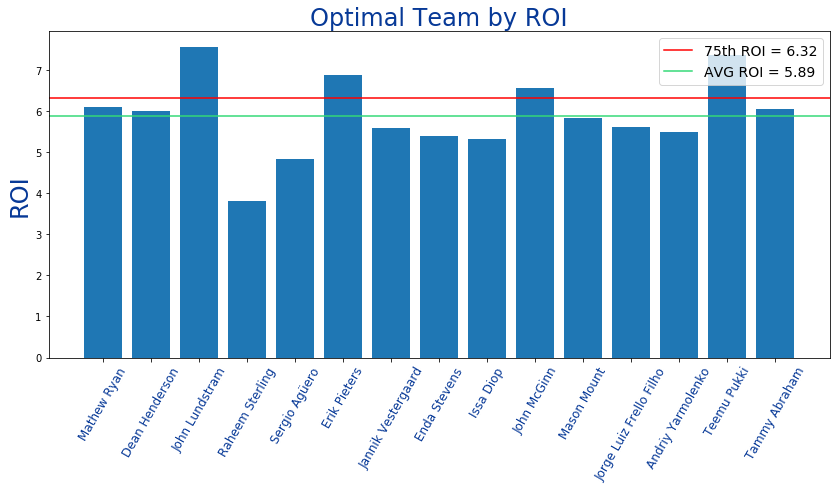

In [76]:
money_x = money_df.roi
money_y = money_df.name
ST_75th = round(money_df.describe().roi['75%'], 2)
ST_AVG = round(money_df.describe().roi['mean'], 2)

plt.bar(money_y, money_x)
plt.axhline(y=ST_75th, color='r', linestyle='-', label='75th ROI = ' + str(ST_75th))
plt.axhline(y=ST_AVG, color='#33D977', linestyle='-', label='AVG ROI = ' + str(ST_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Optimal Team by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

### Top 10 ROI players by position

In [77]:
GK_df = pd.DataFrame(GK_roi)
GK_df.head(10)

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
0,6,4.6,630,Mathew Ryan,Goalkeeper,3.99,0,6.09,available,36,Brighton,28,353221,329558
1,2,4.5,630,Dean Henderson,Goalkeeper,3.85,0,6.00,available,49,Sheffield Utd,27,136789,51456
2,3,4.5,630,Angus Gunn,Goalkeeper,3.71,0,5.78,available,20,Southampton,26,225752,69623
3,1,4.6,630,Nick Pope,Goalkeeper,3.57,0,5.43,available,90,Burnley,25,718833,187660
4,3,4.5,630,Aaron Ramsdale,Goalkeeper,3.28,0,5.11,available,91,Bournemouth,23,60844,18715
5,0,6.1,630,Ederson Santana de Moraes,Goalkeeper,4.14,0,4.75,available,43,Man City,29,621700,450948
6,0,4.5,630,Tom Heaton,Goalkeeper,3.00,0,4.67,available,7,Aston Villa,21,197636,156569
7,1,5.0,630,Bernd Leno,Goalkeeper,3.00,0,4.20,available,3,Arsenal,21,233672,221192
8,1,5.5,630,Jordan Pickford,Goalkeeper,3.14,0,4.00,available,11,Everton,22,323801,343497
9,0,5.5,540,Hugo Lloris,Goalkeeper,3.66,0,4.00,available,6,Spurs,22,213025,268868


In [78]:
DF_df = pd.DataFrame(DF_roi)
DF_df.head(10)

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
0,7,4.5,598,John Lundstram,Defender,5.11,0,7.56,available,49,Sheffield Utd,34,1629228,207497
1,5,4.8,630,Erik Pieters,Defender,4.71,0,6.88,available,90,Burnley,33,897131,223716
2,6,5.2,618,Jannik Vestergaard,Defender,4.22,0,5.58,available,20,Southampton,29,496560,123733
3,4,5.0,630,Enda Stevens,Defender,3.85,0,5.40,available,49,Sheffield Utd,27,29797,18192
4,2,4.5,630,Issa Diop,Defender,3.42,0,5.33,available,21,West Ham,24,204341,111114
5,2,4.5,619,Ryan Fredericks,Defender,3.48,0,5.33,available,21,West Ham,24,52026,18434
6,3,4.5,630,George Baldock,Defender,3.42,0,5.33,available,49,Sheffield Utd,24,47895,19857
7,3,4.6,630,Tyrone Mings,Defender,3.28,0,5.00,available,7,Aston Villa,23,392438,138341
8,5,4.6,630,Lewis Dunk,Defender,3.28,0,5.00,available,36,Brighton,23,454034,299892
9,0,4.5,630,Matthew Lowton,Defender,3.14,0,4.89,available,90,Burnley,22,68650,25762


In [79]:
MD_df = pd.DataFrame(MD_roi)
MD_df.head(10)

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
0,4,5.8,630,John McGinn,Midfielder,5.42,0,6.55,available,7,Aston Villa,38,775461,276679
1,6,6.7,630,Mason Mount,Midfielder,5.56,0,5.82,available,8,Chelsea,39,2452608,557064
2,5,5.0,592,Jorge Luiz Frello Filho,Midfielder,4.25,0,5.60,available,8,Chelsea,28,246955,190100
3,5,6.0,376,Andriy Yarmolenko,Midfielder,7.88,0,5.50,available,21,West Ham,33,302105,24987
4,6,8.6,398,Riyad Mahrez,Midfielder,10.15,0,5.23,available,43,Man City,45,450080,237346
5,3,7.6,408,David Silva,Midfielder,8.14,0,4.87,available,43,Man City,37,669791,342940
6,2,6.1,485,Erik Lamela,Midfielder,5.37,0,4.75,available,6,Spurs,29,458327,239515
7,3,6.0,622,Emiliano Buendía,Midfielder,4.04,0,4.67,available,45,Norwich,28,161125,76430
8,2,4.6,601,Matteo Guendouzi,Midfielder,3.14,0,4.57,available,3,Arsenal,21,611304,292803
9,0,5.5,421,Anwar El Ghazi,Midfielder,5.33,0,4.55,available,7,Aston Villa,25,38341,27740


In [80]:
ST_df = pd.DataFrame(ST_roi)
ST_df.head(10)

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
0,9,7.2,622,Teemu Pukki,Forward,7.66,0,7.36,available,45,Norwich,53,3116428,619237
1,9,7.6,486,Tammy Abraham,Forward,8.50,0,6.05,available,8,Chelsea,46,2646599,335623
2,4,7.9,607,Callum Wilson,Forward,6.81,0,5.82,available,91,Bournemouth,46,387095,750914
3,5,6.3,618,Joshua King,Forward,5.23,0,5.71,available,91,Bournemouth,36,324088,974348
4,4,6.6,572,Ashley Barnes,Forward,5.03,0,4.85,available,90,Burnley,32,979289,681834
5,6,12.2,470,Sergio Agüero,Forward,11.27,0,4.84,available,43,Man City,59,1124582,444031
6,10,11.0,630,Pierre-Emerick Aubameyang,Forward,7.56,0,4.82,available,3,Arsenal,53,734354,824639
7,4,6.2,575,Chris Wood,Forward,4.38,0,4.52,available,90,Burnley,28,68991,96421
8,4,5.9,361,Danny Ings,Forward,6.46,0,4.41,available,20,Southampton,26,112408,157766
9,4,6.0,604,Wesley Moraes,Forward,3.87,0,4.33,available,7,Aston Villa,26,181517,139404


## Define Clean df for graphing purposes

In [81]:
clean_df.head()

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
386,7,4.5,598,John Lundstram,Defender,5.11,0,7.56,available,49,Sheffield Utd,34,1629228,207497
359,9,7.2,622,Teemu Pukki,Forward,7.66,0,7.36,available,45,Norwich,53,3116428,619237
137,5,4.8,630,Erik Pieters,Defender,4.71,0,6.88,available,90,Burnley,33,897131,223716
171,5,4.6,630,Joel Ward,Defender,4.42,0,6.74,available,31,Crystal Palace,31,232105,62447
39,4,5.8,630,John McGinn,Midfielder,5.42,0,6.55,available,7,Aston Villa,38,775461,276679


In [82]:
graph_roi = []
for row, player in clean_df.iterrows():
    playa = dict(name = player['name'], position = player.position, team=player.team_name, cost = player.cost, points = player.total_points, minutes = player.minutes, ROI = player.roi, pts_per_90min = player.pts_per_90min)
    graph_roi.append(playa)

In [83]:
graph_roi[:3]

[{'name': 'John Lundstram',
  'position': 'Defender',
  'team': 'Sheffield Utd',
  'cost': 4.5,
  'points': 34,
  'minutes': 598,
  'ROI': 7.56,
  'pts_per_90min': 5.11},
 {'name': 'Teemu Pukki',
  'position': 'Forward',
  'team': 'Norwich',
  'cost': 7.2,
  'points': 53,
  'minutes': 622,
  'ROI': 7.36,
  'pts_per_90min': 7.66},
 {'name': 'Erik Pieters',
  'position': 'Defender',
  'team': 'Burnley',
  'cost': 4.8,
  'points': 33,
  'minutes': 630,
  'ROI': 6.88,
  'pts_per_90min': 4.71}]

### Graph by ROI

In [84]:
GK_graph = clean_df[clean_df['position'] == 'Goalkeeper']
DF_graph = clean_df[clean_df['position'] == 'Defender']
MD_graph = clean_df[clean_df['position'] == 'Midfielder']
ST_graph = clean_df[clean_df['position'] == 'Forward']

### Graph by 90_min Stat

In [85]:
sorted_players_90min = sorted(graph_roi, key = lambda x: x['pts_per_90min'], reverse = True)

#define filter of minimum time played
min_min = min_min
sorted_players_90min = [player for player in sorted_players_90min if player['minutes'] >= min_min]

In [86]:
sorted_players_90min[:3]

[{'name': 'Sergio Agüero',
  'position': 'Forward',
  'team': 'Man City',
  'cost': 12.2,
  'points': 59,
  'minutes': 470,
  'ROI': 4.84,
  'pts_per_90min': 11.27},
 {'name': 'Riyad Mahrez',
  'position': 'Midfielder',
  'team': 'Man City',
  'cost': 8.6,
  'points': 45,
  'minutes': 398,
  'ROI': 5.23,
  'pts_per_90min': 10.15},
 {'name': 'Bernardo Mota Veiga de Carvalho e Silva',
  'position': 'Midfielder',
  'team': 'Man City',
  'cost': 7.9,
  'points': 34,
  'minutes': 341,
  'ROI': 4.3,
  'pts_per_90min': 8.95}]

In [87]:
df_90min = pd.DataFrame(sorted_players_90min)

In [88]:
df_90min.head()

,ROI,cost,minutes,name,points,position,pts_per_90min,team
0,4.84,12.2,470,Sergio Agüero,59,Forward,11.27,Man City
1,5.23,8.6,398,Riyad Mahrez,45,Midfielder,10.15,Man City
2,4.30,7.9,341,Bernardo Mota Veiga de Carvalho e Silva,34,Midfielder,8.95,Man City
3,6.05,7.6,486,Tammy Abraham,46,Forward,8.50,Chelsea
4,4.87,7.6,408,David Silva,37,Midfielder,8.14,Man City


In [89]:
GK_90min_graph = df_90min[df_90min['position'] == 'Goalkeeper']
DF_90min_graph = df_90min[df_90min['position'] == 'Defender']
MD_90min_graph = df_90min[df_90min['position'] == 'Midfielder']
ST_90min_graph = df_90min[df_90min['position'] == 'Forward']

In [90]:
GK_90min_graph.head()

,ROI,cost,minutes,name,points,position,pts_per_90min,team
51,6.27,5.1,630,Rui Pedro dos Santos Patrício,32,Goalkeeper,4.56,Wolves
68,5.36,5.6,630,David de Gea,30,Goalkeeper,4.28,Man Utd
81,4.75,6.1,630,Ederson Santana de Moraes,29,Goalkeeper,4.14,Man City
87,6.09,4.6,630,Mathew Ryan,28,Goalkeeper,3.99,Brighton
93,6.00,4.5,630,Dean Henderson,27,Goalkeeper,3.85,Sheffield Utd


In [91]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6

## Top 10 Keepers ROI

<function matplotlib.pyplot.show(*args, **kw)>

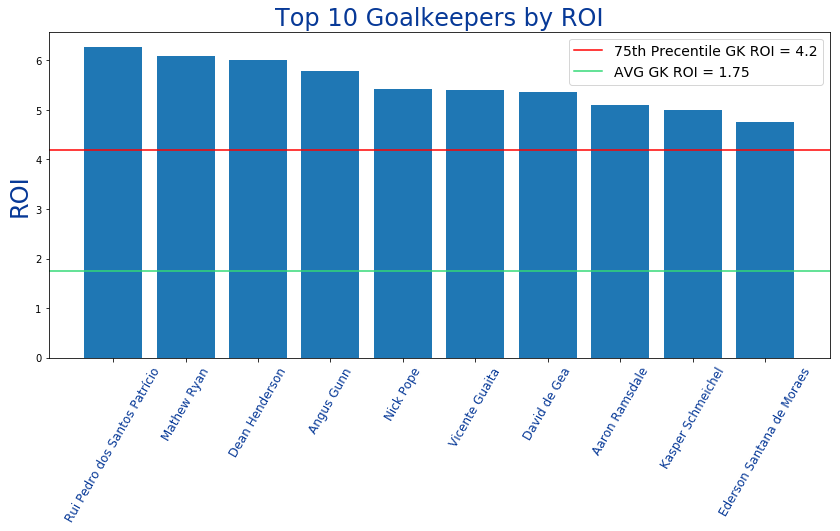

In [92]:
GK_x = GK_graph[:10].roi
GK_y = GK_graph[:10].name
GK_75th = round(GK_graph.describe().roi['75%'], 2)
GK_AVG = round(GK_graph.describe().roi['mean'], 2)

plt.bar(GK_y, GK_x)
plt.axhline(y=GK_75th, color='r', linestyle='-', label='75th Precentile GK ROI = ' + str(GK_75th))
plt.axhline(y=GK_AVG, color='#33D977', linestyle='-', label='AVG GK ROI = ' + str(GK_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Goalkeepers by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

## Top 10 Keepers 90_min

<function matplotlib.pyplot.show(*args, **kw)>

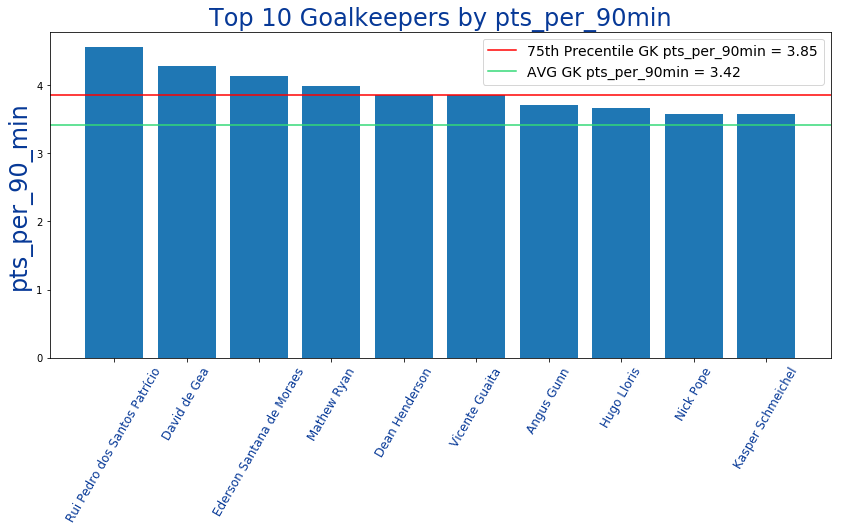

In [93]:
GK_x = GK_90min_graph[:10].pts_per_90min
GK_y = GK_90min_graph[:10].name
GK_75th = round(GK_90min_graph.describe().pts_per_90min['75%'], 2)
GK_AVG = round(GK_90min_graph.describe().pts_per_90min['mean'], 2)

plt.bar(GK_y, GK_x)
plt.axhline(y=GK_75th, color='r', linestyle='-', label='75th Precentile GK pts_per_90min = ' + str(GK_75th))
plt.axhline(y=GK_AVG, color='#33D977', linestyle='-', label='AVG GK pts_per_90min = ' + str(GK_AVG))
plt.ylabel('pts_per_90_min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Goalkeepers by pts_per_90min', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

## Top 10 Defenders

<function matplotlib.pyplot.show(*args, **kw)>

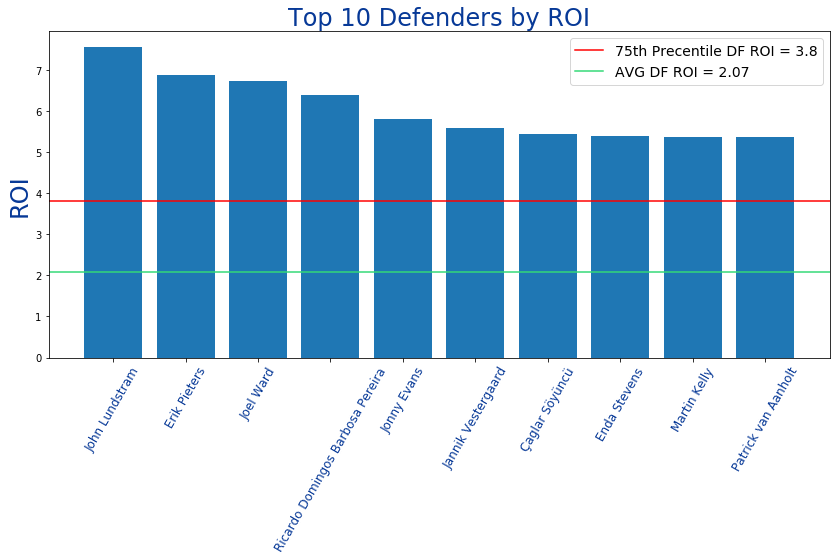

In [94]:
DF_x = DF_graph[:10].roi
DF_y = DF_graph[:10].name
DF_75th = round(DF_graph.describe().roi['75%'], 2)
DF_AVG = round(DF_graph.describe().roi['mean'], 2)

plt.bar(DF_y, DF_x)
plt.axhline(y=DF_75th, color='r', linestyle='-', label='75th Precentile DF ROI = ' + str(DF_75th))
plt.axhline(y=DF_AVG, color='#33D977', linestyle='-', label='AVG DF ROI = ' + str(DF_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Defenders by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

## Top 10 Defenders 90min Stat

<function matplotlib.pyplot.show(*args, **kw)>

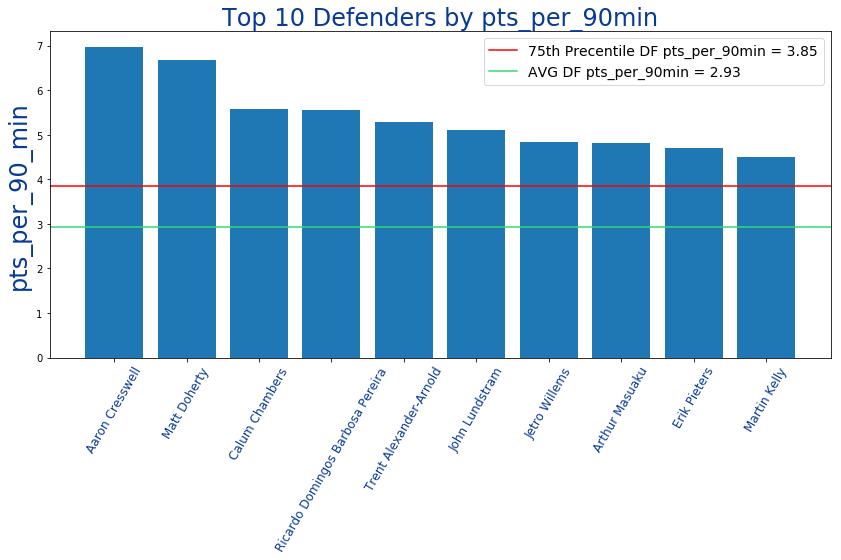

In [95]:
DF_x = DF_90min_graph[:10].pts_per_90min
DF_y = DF_90min_graph[:10].name
DF_75th = round(DF_90min_graph.describe().pts_per_90min['75%'], 2)
DF_AVG = round(DF_90min_graph.describe().pts_per_90min['mean'], 2)

plt.bar(DF_y, DF_x)
plt.axhline(y=DF_75th, color='r', linestyle='-', label='75th Precentile DF pts_per_90min = ' + str(DF_75th))
plt.axhline(y=DF_AVG, color='#33D977', linestyle='-', label='AVG DF pts_per_90min = ' + str(DF_AVG))
plt.ylabel('pts_per_90_min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Defenders by pts_per_90min', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

## Top 10 Midfielders

<function matplotlib.pyplot.show(*args, **kw)>

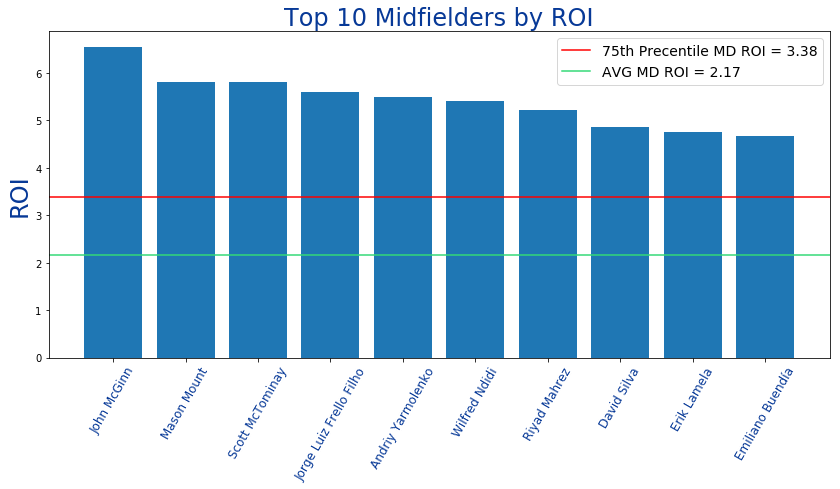

In [96]:
MD_x = MD_graph[:10].roi
MD_y = MD_graph[:10].name
MD_75th = round(MD_graph.describe().roi['75%'], 2)
MD_AVG = round(MD_graph.describe().roi['mean'], 2)

plt.bar(MD_y, MD_x)
plt.axhline(y=MD_75th, color='r', linestyle='-', label='75th Precentile MD ROI = ' + str(MD_75th))
plt.axhline(y=MD_AVG, color='#33D977', linestyle='-', label='AVG MD ROI = ' + str(MD_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Midfielders by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

## Top 10 Midfielders 90min Stat

<function matplotlib.pyplot.show(*args, **kw)>

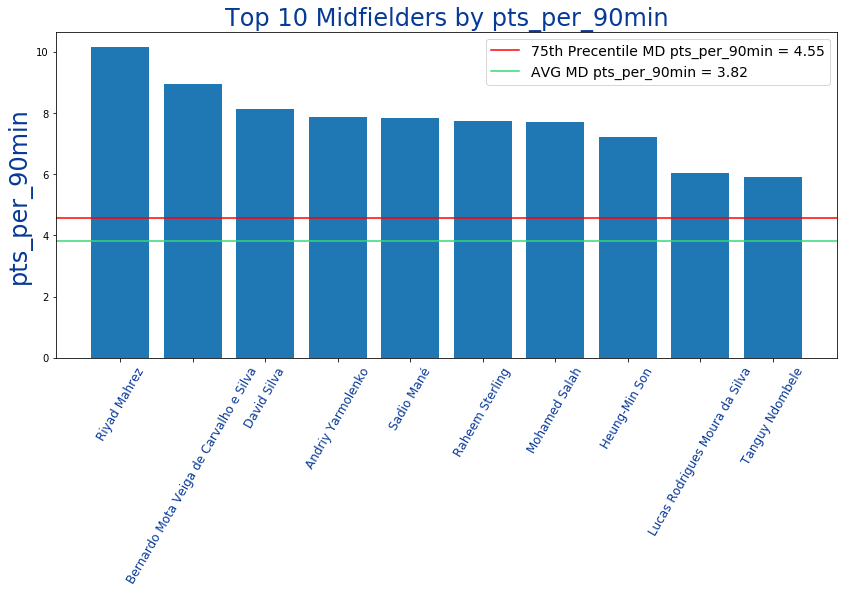

In [97]:
MD_x = MD_90min_graph[:10].pts_per_90min
MD_y = MD_90min_graph[:10].name
MD_75th = round(MD_90min_graph.describe().pts_per_90min['75%'], 2)
MD_AVG = round(MD_90min_graph.describe().pts_per_90min['mean'], 2)

plt.bar(MD_y, MD_x)
plt.axhline(y=MD_75th, color='r', linestyle='-', label='75th Precentile MD pts_per_90min = ' + str(MD_75th))
plt.axhline(y=MD_AVG, color='#33D977', linestyle='-', label='AVG MD pts_per_90min = ' + str(MD_AVG))
plt.ylabel('pts_per_90min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Midfielders by pts_per_90min', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

## Top 10 Strikers

<function matplotlib.pyplot.show(*args, **kw)>

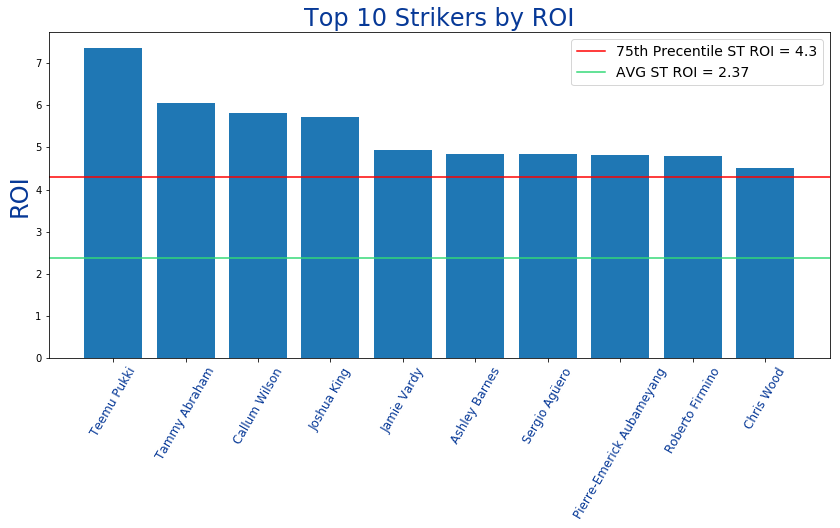

In [98]:
ST_x = ST_graph[:10].roi
ST_y = ST_graph[:10].name
ST_75th = round(ST_graph.describe().roi['75%'], 2)
ST_AVG = round(ST_graph.describe().roi['mean'], 2)

plt.bar(ST_y, ST_x)
plt.axhline(y=ST_75th, color='r', linestyle='-', label='75th Precentile ST ROI = ' + str(ST_75th))
plt.axhline(y=ST_AVG, color='#33D977', linestyle='-', label='AVG ST ROI = ' + str(ST_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Strikers by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

## Top 10 Strikers 90min Stat

<function matplotlib.pyplot.show(*args, **kw)>

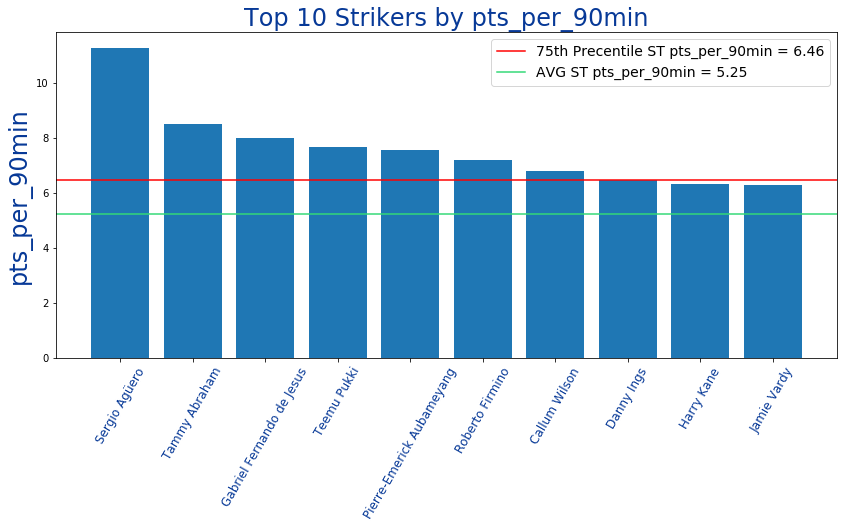

In [99]:
ST_x = ST_90min_graph[:10].pts_per_90min
ST_y = ST_90min_graph[:10].name
ST_75th = round(ST_90min_graph.describe().pts_per_90min['75%'], 2)
ST_AVG = round(ST_90min_graph.describe().pts_per_90min['mean'], 2)

plt.bar(ST_y, ST_x)
plt.axhline(y=ST_75th, color='r', linestyle='-', label='75th Precentile ST pts_per_90min = ' + str(ST_75th))
plt.axhline(y=ST_AVG, color='#33D977', linestyle='-', label='AVG ST pts_per_90min = ' + str(ST_AVG))
plt.ylabel('pts_per_90min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Strikers by pts_per_90min', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

In [100]:
team_df

,code,strength,Team,name,Played,W,L,D,GF,GA,GD,Pts
Position,,,,,,,,,,,,
1,14,5,LIV,Liverpool,7,7,0,0,18,5,+13,21
2,43,5,MCI,Man City,7,5,1,1,27,7,+20,16
3,13,3,LEI,Leicester,7,4,1,2,13,5,+8,14
4,3,4,ARS,Arsenal,7,3,1,3,12,11,+1,12
5,21,3,WHU,West Ham,7,3,1,3,10,9,+1,12
6,6,4,TOT,Spurs,7,3,2,2,14,9,+5,11
7,8,4,CHE,Chelsea,7,3,2,2,14,13,+1,11
8,91,3,BOU,Bournemouth,7,3,2,2,13,12,+1,11
9,31,3,CRY,Crystal Palace,7,3,2,2,6,7,-1,11


### Team Stats

In [101]:
teams_stats = team_df.iloc[:,2:12]

In [102]:
teams_stats.GF = [int(item) for item in teams_stats.GF]
teams_stats.GA = [int(item) for item in teams_stats.GA]

In [103]:
teams_stats

,Team,name,Played,W,L,D,GF,GA,GD,Pts
Position,,,,,,,,,,
1,LIV,Liverpool,7,7,0,0,18,5,+13,21
2,MCI,Man City,7,5,1,1,27,7,+20,16
3,LEI,Leicester,7,4,1,2,13,5,+8,14
4,ARS,Arsenal,7,3,1,3,12,11,+1,12
5,WHU,West Ham,7,3,1,3,10,9,+1,12
6,TOT,Spurs,7,3,2,2,14,9,+5,11
7,CHE,Chelsea,7,3,2,2,14,13,+1,11
8,BOU,Bournemouth,7,3,2,2,13,12,+1,11
9,CRY,Crystal Palace,7,3,2,2,6,7,-1,11


### Worst/ Best  Defence vs. Offence

In [104]:
worst_defence_df = teams_stats.sort_values(by = ['GA'], ascending = False)

In [105]:
worst_defence_df.head()

,Team,name,Played,W,L,D,GF,GA,GD,Pts
Position,,,,,,,,,,
20,WAT,Watford,7,0,5,2,4,20,-16,2
17,NOR,Norwich,7,2,5,0,9,16,-7,6
19,NEW,Newcastle,7,1,4,2,4,13,-9,5
7,CHE,Chelsea,7,3,2,2,14,13,+1,11
8,BOU,Bournemouth,7,3,2,2,13,12,+1,11


In [106]:
best_defence_df = teams_stats.sort_values(by = ['GA'], ascending = True)

In [107]:
best_defence_df.head()

,Team,name,Played,W,L,D,GF,GA,GD,Pts
Position,,,,,,,,,,
1,LIV,Liverpool,7,7,0,0,18,5,+13,21
3,LEI,Leicester,7,4,1,2,13,5,+8,14
12,SHU,Sheffield Utd,7,2,3,2,7,7,0,8
9,CRY,Crystal Palace,7,3,2,2,6,7,-1,11
10,MUN,Man Utd,7,2,2,3,9,7,+2,9


In [108]:
GA = list(zip(worst_defence_df.name, worst_defence_df.GA))
GA_bottom5 = GA[:7]
GA_top5 = sorted(GA[-7:], key = lambda x: x[1])

In [109]:
GA_bottom5, GA_top5

([('Watford', 20),
  ('Norwich', 16),
  ('Newcastle', 13),
  ('Chelsea', 13),
  ('Bournemouth', 12),
  ('Everton', 12),
  ('Wolves', 11)],
 [('Leicester', 5),
  ('Liverpool', 5),
  ('Sheffield Utd', 7),
  ('Man City', 7),
  ('Man Utd', 7),
  ('Crystal Palace', 7),
  ('West Ham', 9)])

In [110]:
teams_stats.GA.median()

10.5

<function matplotlib.pyplot.show(*args, **kw)>

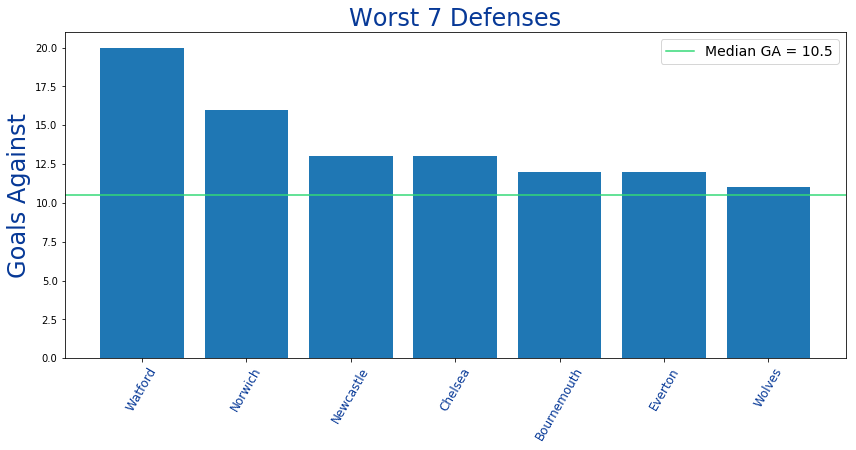

In [111]:
X = [item[0] for item in GA_bottom5]
Y = [int(item[1]) for item in GA_bottom5]

median = teams_stats.GA.median()

plt.bar(X, Y)
plt.ylim(bottom=0)
plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GA = ' + str(median))
plt.ylabel('Goals Against', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Worst 7 Defenses', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

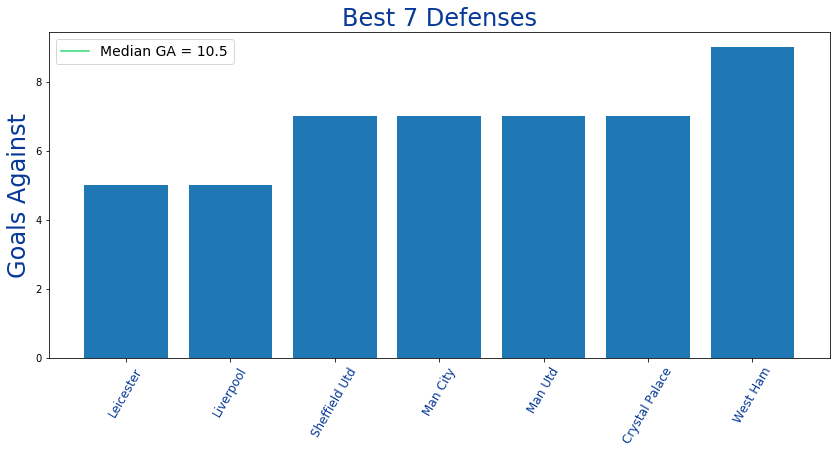

In [112]:
X = [item[0] for item in GA_top5]
Y = [int(item[1]) for item in GA_top5]

median = teams_stats.GA.median()

plt.bar(X, Y)
plt.ylim(bottom=0)
plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GA = ' + str(median))
plt.ylabel('Goals Against', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Best 7 Defenses', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.show

In [113]:
offense_df = teams_stats.sort_values(by = ['GF'], ascending = False)

In [114]:
offense_df.head()

,Team,name,Played,W,L,D,GF,GA,GD,Pts
Position,,,,,,,,,,
2,MCI,Man City,7,5,1,1,27,7,+20,16
1,LIV,Liverpool,7,7,0,0,18,5,+13,21
6,TOT,Spurs,7,3,2,2,14,9,+5,11
7,CHE,Chelsea,7,3,2,2,14,13,+1,11
8,BOU,Bournemouth,7,3,2,2,13,12,+1,11


In [115]:
GF = list(zip(offense_df.name, offense_df.GF))
GF_top5 = GF[:7]
GF_bottom5 = GF[-7:]

In [116]:
GF_top5, GF_bottom5

([('Man City', 27),
  ('Liverpool', 18),
  ('Spurs', 14),
  ('Chelsea', 14),
  ('Bournemouth', 13),
  ('Leicester', 13),
  ('Arsenal', 12)],
 [('Sheffield Utd', 7),
  ('Southampton', 7),
  ('Crystal Palace', 6),
  ('Everton', 6),
  ('Brighton', 5),
  ('Newcastle', 4),
  ('Watford', 4)])

<function matplotlib.pyplot.show(*args, **kw)>

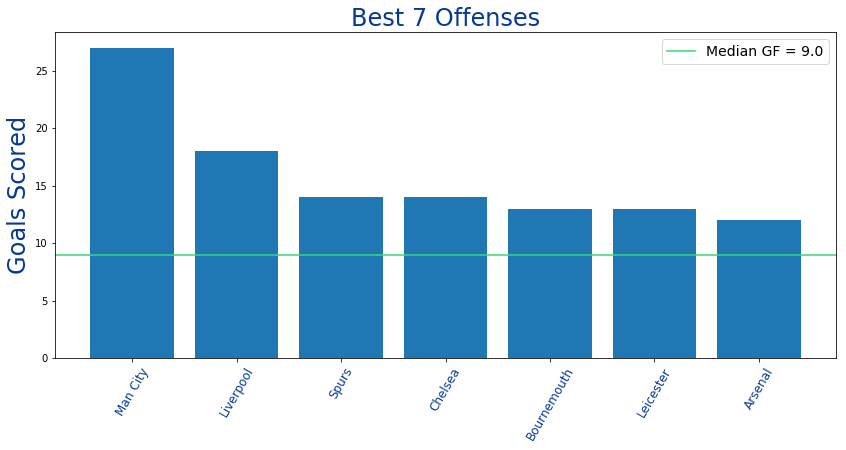

In [117]:
X = [item[0] for item in GF_top5]
Y = [int(item[1]) for item in GF_top5]

median = teams_stats.GF.median()

plt.bar(X, Y)
plt.ylim(bottom=0)
plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Goals Scored', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Best 7 Offenses', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

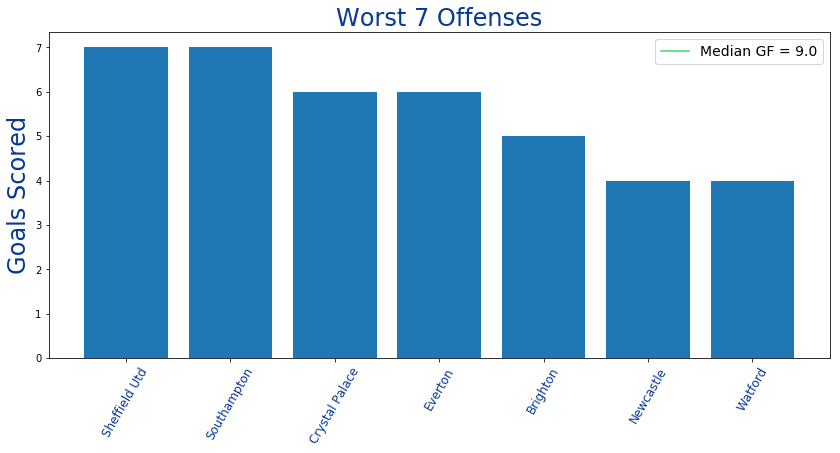

In [118]:
X = [item[0] for item in GF_bottom5]
Y = [int(item[1]) for item in GF_bottom5]

median = teams_stats.GF.median()

plt.bar(X, Y)
plt.ylim(bottom=0)
plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Goals Scored', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Worst 7 Offenses', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.show

In [119]:
stats_df = player_df[player_df.minutes >= min_min]

In [120]:
stats_df.tail()

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
375,0,4.4,181,Sam Byram,Defender,0.99,0,0.45,available,45,Norwich,2,3849,5212
159,0,4.8,453,Kurt Zouma,Defender,0.40,0,0.42,available,8,Chelsea,2,48887,154416
209,0,5.4,360,Fabian Delph,Defender,0.50,0,0.37,available,11,Everton,2,7176,17867
358,0,4.0,270,Grant Hanley,Defender,0.33,0,0.25,injured,45,Norwich,1,209475,134387
467,0,4.7,527,José Holebas,Defender,0.00,0,0.00,available,57,Watford,0,12476,179485


### Cobine Team and Player Stats

In [121]:
team_dic = {item:[] for item in team_names}

for row, player in stats_df.iterrows():
    for name in team_names:
        if player.team_name == name:
            playa = dict(name = player['name'], position = player.position, cost = player.cost, minutes = player.minutes, 
                         points = player.total_points,  roi = player.roi, pts_per_90min = player.pts_per_90min, 
                         bonus = player.bonus, red_cards = player.red_cards)
            team_dic[name].append(playa)

In [122]:
stats_df.head()

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
386,7,4.5,598,John Lundstram,Defender,5.11,0,7.56,available,49,Sheffield Utd,34,1629228,207497
359,9,7.2,622,Teemu Pukki,Forward,7.66,0,7.36,available,45,Norwich,53,3116428,619237
137,5,4.8,630,Erik Pieters,Defender,4.71,0,6.88,available,90,Burnley,33,897131,223716
171,5,4.6,630,Joel Ward,Defender,4.42,0,6.74,available,31,Crystal Palace,31,232105,62447
39,4,5.8,630,John McGinn,Midfielder,5.42,0,6.55,available,7,Aston Villa,38,775461,276679


In [123]:
team_dic['Liverpool']

[{'name': 'Joel Matip',
  'position': 'Defender',
  'cost': 5.5,
  'minutes': 540,
  'points': 30,
  'roi': 5.45,
  'pts_per_90min': 4.99,
  'bonus': 4,
  'red_cards': 0},
 {'name': 'Trent Alexander-Arnold',
  'position': 'Defender',
  'cost': 7.2,
  'minutes': 630,
  'points': 37,
  'roi': 5.14,
  'pts_per_90min': 5.28,
  'bonus': 2,
  'red_cards': 0},
 {'name': 'Roberto Firmino',
  'position': 'Forward',
  'cost': 9.6,
  'minutes': 573,
  'points': 46,
  'roi': 4.79,
  'pts_per_90min': 7.21,
  'bonus': 9,
  'red_cards': 0},
 {'name': 'Virgil van Dijk',
  'position': 'Defender',
  'cost': 6.5,
  'minutes': 630,
  'points': 31,
  'roi': 4.77,
  'pts_per_90min': 4.42,
  'bonus': 3,
  'red_cards': 0},
 {'name': 'Adrián San Miguel del Castillo',
  'position': 'Goalkeeper',
  'cost': 4.6,
  'minutes': 591,
  'points': 21,
  'roi': 4.57,
  'pts_per_90min': 3.19,
  'bonus': 0,
  'red_cards': 0},
 {'name': 'Andrew Robertson',
  'position': 'Defender',
  'cost': 6.9,
  'minutes': 630,
  'point

### Get Final Stats per Team using Pandas

In [124]:
team_stats = {item:{} for item in team_names}

for team in team_names:
    active_players = len(stats_df[stats_df.team_name == team].cost)
    tot_cost = round(stats_df[stats_df.team_name == team].cost.sum(), 3)
    tot_pts = round(stats_df[stats_df.team_name == team].total_points.sum(), 3)
    avg_player_roi = round(tot_pts / tot_cost, 3)
    avg_pts_per_player = round(tot_pts / active_players, 3)
    
    stats = dict(active_players = active_players, tot_cost = tot_cost, tot_pts = tot_pts,
               avg_pts_per_player = avg_pts_per_player,  avg_player_roi =  avg_player_roi)
    
    team_stats[team].update(stats)
    
    

In [125]:
team_stats['Newcastle']

{'active_players': 14,
 'tot_cost': 69.3,
 'tot_pts': 217,
 'avg_pts_per_player': 15.5,
 'avg_player_roi': 3.131}

In [126]:
team_stats_df = pd.DataFrame(team_stats).T

In [127]:
team_stats_df.sort_values(by = ['avg_pts_per_player'], ascending = False, inplace = True)

In [128]:
team_stats_df

,active_players,avg_player_roi,avg_pts_per_player,tot_cost,tot_pts
Liverpool,12.0,4.092,29.667,87.0,356.0
Man City,16.0,3.747,27.750,118.5,444.0
Leicester,14.0,4.053,23.071,79.7,323.0
West Ham,13.0,4.209,22.923,70.8,298.0
Burnley,13.0,3.873,20.615,69.2,268.0
Wolves,13.0,3.626,19.385,69.5,252.0
Sheffield Utd,13.0,3.899,19.077,63.6,248.0
Spurs,15.0,2.911,18.667,96.2,280.0
Man Utd,15.0,2.974,18.000,90.8,270.0
Crystal Palace,15.0,3.380,17.800,79.0,267.0


### Build a team using 90min Stat

In [129]:
#define money team as empty list and list that tracks count of players selectd per team
money_team = []
players_selected = []
teams_selected = []

#Instantiate initial count per position
#Current players selected for each position
DF_curr = 0
MD_curr = 0 
ST_curr = 0

GK_budget = budget*GK_coef
print(GK_budget)

for item in GK_90min:
    if item['cost'] <= 5.5 and item['cost'] <= GK_budget:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        GK_budget -= item['cost']
        print('Player Selected: ' + item['name'])
        print('GK budget left: ' + str(GK_budget))

print(players_selected)
print(teams_selected)

9.5
Player Selected: Mathew Ryan
GK budget left: 4.9
Player Selected: Dean Henderson
GK budget left: 0.40000000000000036
['Mathew Ryan', 'Dean Henderson']
['Brighton', 'Sheffield Utd']


### Select top 3 players by points per position

In [130]:
DF_budget = budget*DF_coef + GK_budget
MD_budget = budget*MD_coef
ST_budget = budget*ST_coef

print(DF_budget, MD_budget, ST_budget)

#Select Top Defender
money_team.append(DF_pts[0])
players_selected.append(DF_pts[0]['name'])
teams_selected.append(DF_pts[0]['team_name'])
DF_budget -= DF_pts[0]['cost']
DF_curr += 1
print('Player Selected: ' + DF_pts[0]['name'])
print('DF budget left: ' + str(DF_budget))

#Select Top Midfielder
money_team.append(MD_pts[0])
players_selected.append(MD_pts[0]['name'])
teams_selected.append(MD_pts[0]['team_name'])
MD_budget -= MD_pts[0]['cost']
MD_curr += 1
print('Player Selected: ' + MD_pts[0]['name'])
print('MD budget left: ' + str(MD_budget))


print(players_selected)
print(teams_selected)

28.9 36.0 26.0
Player Selected: John Lundstram
DF budget left: 24.4
Player Selected: Raheem Sterling
MD budget left: 23.9
['Mathew Ryan', 'Dean Henderson', 'John Lundstram', 'Raheem Sterling']
['Brighton', 'Sheffield Utd', 'Sheffield Utd', 'Man City']


In [131]:
#Select Top Striker

for item in ST_pts[:3]:
    if teams_selected.count(item['team_name']) < 3 and len(money_team) == 4:
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            ST_budget -= item['cost']
            ST_curr += 1
            print('Player Selected: ' + item['name'])
            print('ST budget left: ' + str(ST_budget))
    break

print(len(money_team))
print(players_selected)
print(teams_selected)

Player Selected: Sergio Agüero
ST budget left: 13.8
5
['Mathew Ryan', 'Dean Henderson', 'John Lundstram', 'Raheem Sterling', 'Sergio Agüero']
['Brighton', 'Sheffield Utd', 'Sheffield Utd', 'Man City', 'Man City']


In [132]:
print(DF_curr, MD_curr, ST_curr)

1 1 1


In [133]:
print(DF, MD, ST)

3 4 3


### Fill rest of team with 90_min_stats

In [134]:
for item in DF_90min:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < DF_budget and DF_curr < DF:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        DF_budget -= item['cost']
        DF_curr += 1
        print('Player Selected: ' + item['name'])
        print('DF budget left: ' + str(DF_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and DF_max != DF_curr and item['cost'] <= DF_budget / (DF_max - DF_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            DF_budget -= item['cost']
            DF_curr += 1
            print('Player Selected: ' + item['name'])
            print('DF budget left: ' + str(DF_budget))
            print('# of DFs selected: ' + str(DF_curr))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Aaron Cresswell
DF budget left: 19.5
Player Selected: Calum Chambers
DF budget left: 15.1
Player Selected: Arthur Masuaku
DF budget left: 10.6
# of DFs selected: 4
Player Selected: Erik Pieters
DF budget left: 5.8
# of DFs selected: 5
9
['Mathew Ryan', 'Dean Henderson', 'John Lundstram', 'Raheem Sterling', 'Sergio Agüero', 'Aaron Cresswell', 'Calum Chambers', 'Arthur Masuaku', 'Erik Pieters']
['Brighton', 'Sheffield Utd', 'Sheffield Utd', 'Man City', 'Man City', 'West Ham', 'Arsenal', 'West Ham', 'Burnley']


In [135]:
#move leftover DF budget to MD budget
MD_budget += DF_budget

for item in MD_90min:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < MD_budget and MD_curr < MD:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        MD_budget -= item['cost']
        MD_curr += 1
        print('Player Selected: ' + item['name'])
        print('MD budget left: ' + str(MD_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and MD_max != MD_curr and item['cost'] <= MD_budget / (MD_max - MD_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            MD_budget -= item['cost']
            MD_curr += 1
            print('Player Selected: ' + item['name'])
            print('MD budget left: ' + str(MD_budget))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Riyad Mahrez
MD budget left: 21.1
Player Selected: Andriy Yarmolenko
MD budget left: 15.100000000000001
Player Selected: Heung-Min Son
MD budget left: 5.400000000000002
Player Selected: Lucas Torreira
MD budget left: 0.6000000000000023
13
['Mathew Ryan', 'Dean Henderson', 'John Lundstram', 'Raheem Sterling', 'Sergio Agüero', 'Aaron Cresswell', 'Calum Chambers', 'Arthur Masuaku', 'Erik Pieters', 'Riyad Mahrez', 'Andriy Yarmolenko', 'Heung-Min Son', 'Lucas Torreira']
['Brighton', 'Sheffield Utd', 'Sheffield Utd', 'Man City', 'Man City', 'West Ham', 'Arsenal', 'West Ham', 'Burnley', 'Man City', 'West Ham', 'Spurs', 'Arsenal']


In [136]:
#move leftover MD budget to ST budget
ST_budget += MD_budget

for item in ST_90min:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < ST_budget and ST_curr < ST:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        ST_budget -= item['cost']
        ST_curr += 1
        print('Player Selected: ' + item['name'])
        print('ST budget left: ' + str(ST_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and ST_max != ST_curr and item['cost'] <= ST_budget / (ST_max - ST_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            ST_budget -= item['cost']
            ST_curr += 1
            print('Player Selected: ' + item['name'])
            print('ST budget left: ' + str(ST_budget))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Tammy Abraham
ST budget left: 6.8000000000000025
Player Selected: Danny Ings
ST budget left: 0.9000000000000021
15
['Mathew Ryan', 'Dean Henderson', 'John Lundstram', 'Raheem Sterling', 'Sergio Agüero', 'Aaron Cresswell', 'Calum Chambers', 'Arthur Masuaku', 'Erik Pieters', 'Riyad Mahrez', 'Andriy Yarmolenko', 'Heung-Min Son', 'Lucas Torreira', 'Tammy Abraham', 'Danny Ings']
['Brighton', 'Sheffield Utd', 'Sheffield Utd', 'Man City', 'Man City', 'West Ham', 'Arsenal', 'West Ham', 'Burnley', 'Man City', 'West Ham', 'Spurs', 'Arsenal', 'Chelsea', 'Southampton']


In [137]:
money_df = pd.DataFrame(money_team)

In [138]:
money_df

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
0,6,4.6,630,Mathew Ryan,Goalkeeper,3.99,0,6.09,available,36,Brighton,28,353221,329558
1,2,4.5,630,Dean Henderson,Goalkeeper,3.85,0,6.00,available,49,Sheffield Utd,27,136789,51456
2,7,4.5,598,John Lundstram,Defender,5.11,0,7.56,available,49,Sheffield Utd,34,1629228,207497
3,4,12.1,535,Raheem Sterling,Midfielder,7.72,0,3.80,available,43,Man City,46,1197549,885457
4,6,12.2,470,Sergio Agüero,Forward,11.27,0,4.84,available,43,Man City,59,1124582,444031
5,2,4.9,270,Aaron Cresswell,Defender,6.97,0,4.29,available,21,West Ham,21,105542,20728
6,0,4.4,225,Calum Chambers,Defender,5.58,0,3.18,available,3,Arsenal,14,50317,49156
7,3,4.5,336,Arthur Masuaku,Defender,4.81,1,4.00,available,21,West Ham,18,84971,54732
8,5,4.8,630,Erik Pieters,Defender,4.71,0,6.88,available,90,Burnley,33,897131,223716
9,6,8.6,398,Riyad Mahrez,Midfielder,10.15,0,5.23,available,43,Man City,45,450080,237346


<function matplotlib.pyplot.show(*args, **kw)>

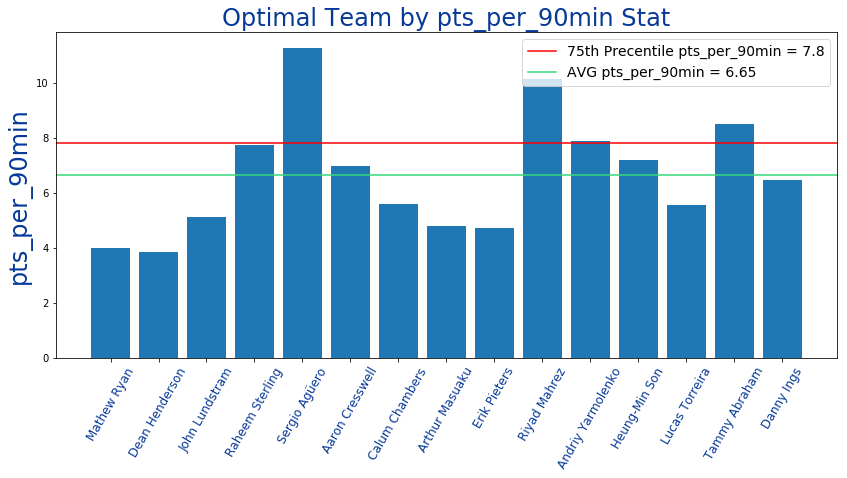

In [139]:
money_x = money_df.pts_per_90min
money_y = money_df.name
ST_75th = round(money_df.describe().pts_per_90min['75%'], 2)
ST_AVG = round(money_df.describe().pts_per_90min['mean'], 2)

plt.bar(money_y, money_x)
plt.axhline(y=ST_75th, color='r', linestyle='-', label='75th Precentile pts_per_90min = ' + str(ST_75th))
plt.axhline(y=ST_AVG, color='#33D977', linestyle='-', label='AVG pts_per_90min = ' + str(ST_AVG))
plt.ylabel('pts_per_90min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Optimal Team by pts_per_90min Stat', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

In [140]:
top100_users = pd.read_csv('fEPL_user_data_test.csv', index_col='users')

In [141]:
top100_users.head()

,rank,user_id_num,total_points,game_week_points,GKP_1,GKP_2,DEF_1,DEF_2,DEF_3,DEF_4,DEF_5,MID_1,MID_2,MID_3,MID_4,MID_5,FWD_1,FWD_2,FWD_3,user_team_pages
users,,,,,,,,,,,,,,,,,,,,
medhat shawky,1,1240736,530,41,Adrián-LIV-start,Pope-BUR-sub,Guilbert-AVL-start,Mings-AVL-start,Aurier-TOT-start,Otamendi-MCI-start,Lundstram-SHU-sub,McGinn-AVL-start,Son-TOT-start,Salah-LIV-start,De Bruyne-MCI-start,Mané-LIV-start,Abraham-CHE-start,Greenwood-MUN-sub,Kean-EVE-sub,https://fantasy.premierleague.com/entry/124073...
david croley,2,1966144,526,59,Heaton-AVL-start,Ryan-BHA-sub,Pereira-LEI-start,Otamendi-MCI-start,Robertson-LIV-start,Mings-AVL-sub,Dunk-BHA-sub,Mount-CHE-start,Mané-LIV-start,McGinn-AVL-start,De Bruyne-MCI-start,Cantwell-NOR-sub,Pukki-NOR-start,Abraham-CHE-start,Agüero-MCI-start,https://fantasy.premierleague.com/entry/196614...
Luke Goodwin,3,4902703,526,58,Heaton-AVL-start,Ryan-BHA-sub,Robertson-LIV-start,Diop-WHU-start,Vertonghen-TOT-start,Kelly-CRY-sub,Dunk-BHA-sub,Guendouzi-ARS-start,Sterling-MCI-start,De Bruyne-MCI-start,Bernardo Silva-MCI-start,Oriol Romeu-SOU-sub,Pukki-NOR-start,Aubameyang-ARS-start,Vardy-LEI-start,https://fantasy.premierleague.com/entry/490270...
nick tanner,4,568651,522,68,Ryan-BHA-start,McGovern-NOR-sub,Guilbert-AVL-start,Rico-BOU-start,Lundstram-SHU-start,Kelly-CRY-sub,Dunk-BHA-sub,Sterling-MCI-start,Mané-LIV-start,Mount-CHE-start,Salah-LIV-start,Cantwell-NOR-sub,Abraham-CHE-start,Pukki-NOR-start,Vardy-LEI-start,https://fantasy.premierleague.com/entry/568651...
Boyko Iliev,5,191908,521,54,Patrício-WOL-start,Pope-BUR-sub,Boly-WOL-start,Alexander-Arnold-LIV-start,Mee-BUR-start,Mendy-MCI-sub,O'Connell-SHU-sub,Mount-CHE-start,Lamela-TOT-start,De Bruyne-MCI-start,Mané-LIV-start,Cantwell-NOR-sub,Pukki-NOR-start,Abraham-CHE-start,Callum Wilson-BOU-start,https://fantasy.premierleague.com/entry/191908...


### Function to extract names from player string

In [142]:
def partition_names(names_list):
    clean_list = [item.partition("-")[0] for item in names_list]
    return clean_list

### Function to get the list of all selected players by position

In [143]:
def get_top100_teams(team_df):
    #create lists by position
    #GK_list
    GK_list = list(team_df.GKP_1)
    GK_list.extend(list(team_df.GKP_2))
    GK_final = partition_names(GK_list)
    
    #DF_list
    DF_list = list(team_df.DEF_1)
    DF_list.extend(list(team_df.DEF_2))
    DF_list.extend(list(team_df.DEF_3))
    DF_list.extend(list(team_df.DEF_4))
    DF_list.extend(list(team_df.DEF_5))
    DF_final = partition_names(DF_list)
    
    #MD_list
    MD_list = list(team_df.MID_1)
    MD_list.extend(list(team_df.MID_2))
    MD_list.extend(list(team_df.MID_3))
    MD_list.extend(list(team_df.MID_4))
    MD_list.extend(list(team_df.MID_5))
    MD_final = partition_names(MD_list)
    
    #ST_list
    ST_list = list(team_df.FWD_1)
    ST_list.extend(list(team_df.FWD_2))
    ST_list.extend(list(team_df.FWD_3))
    ST_final = partition_names(ST_list)
    
    return GK_final, DF_final, MD_final, ST_final

In [144]:
#get the final clean list of players per position
GK_final, DF_final, MD_final, ST_final = get_top100_teams(top100_users)[0], get_top100_teams(top100_users)[1], get_top100_teams(top100_users)[2], get_top100_teams(top100_users)[3]

In [145]:
GK_final[:3]

['Adrián', 'Heaton', 'Heaton']

In [146]:
MD_final[:3]

['McGinn', 'Mount', 'Guendouzi']

In [147]:
DF_final[:3]

['Guilbert', 'Pereira', 'Robertson']

In [148]:
ST_final[:3]

['Abraham', 'Pukki', 'Pukki']

### Function to get you top_n players by position ordered by # of times they were picked

In [149]:
def return_top_n(players, top_n = 10):
    ranked = Counter(players).most_common(top_n)
    return ranked

In [150]:
GK_top10 = return_top_n(GK_final)

In [151]:
GK_top10

[('Pope', 35),
 ('Button', 27),
 ('Heaton', 24),
 ('Ryan', 24),
 ('Adrián', 13),
 ('Patrício', 12),
 ('Stekelenburg', 11),
 ('McGovern', 10),
 ('Ederson', 9),
 ('de Gea', 8)]

In [152]:
DF_top10 = return_top_n(DF_final)

In [153]:
DF_top10

[('Lundstram', 76),
 ('Kelly', 50),
 ('Alexander', 48),
 ('van Dijk', 29),
 ('Söyüncü', 23),
 ('Dunk', 20),
 ('Otamendi', 19),
 ('Rico', 19),
 ('Tomori', 17),
 ('Pieters', 16)]

In [154]:
MD_top10 = return_top_n(MD_final)

In [155]:
MD_top10

[('De Bruyne', 92),
 ('Mount', 51),
 ('Cantwell', 48),
 ('Salah', 46),
 ('Sterling', 44),
 ('Son', 27),
 ('Mané', 27),
 ('McGinn', 25),
 ('Dendoncker', 15),
 ('Guendouzi', 11)]

In [156]:
ST_top10 = return_top_n(ST_final)

In [157]:
ST_top10

[('Pukki', 70),
 ('Abraham', 56),
 ('Agüero', 41),
 ('Vardy', 20),
 ('Callum Wilson', 18),
 ('Aubameyang', 16),
 ('Greenwood', 15),
 ('Kane', 15),
 ('Firmino', 14),
 ('King', 7)]

<function matplotlib.pyplot.show(*args, **kw)>

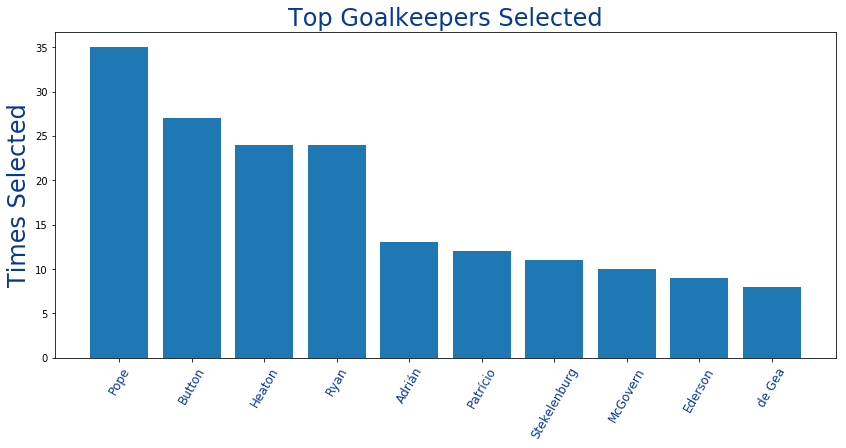

In [158]:
X = [item[0] for item in GK_top10]
Y = [item[1] for item in GK_top10]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top Goalkeepers Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

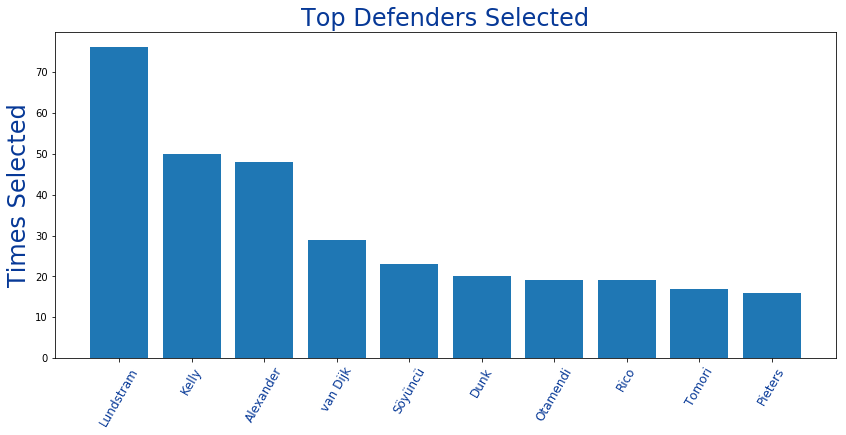

In [159]:
X = [item[0] for item in DF_top10]
Y = [item[1] for item in DF_top10]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top Defenders Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

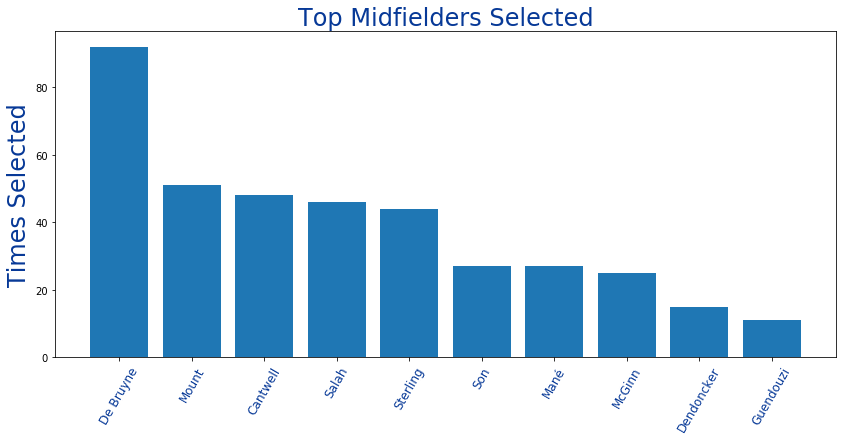

In [160]:
X = [item[0] for item in MD_top10]
Y = [item[1] for item in MD_top10]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top Midfielders Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

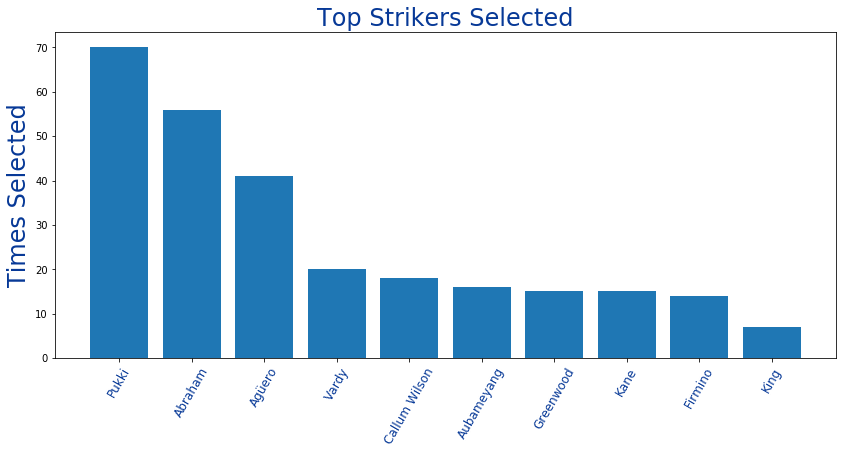

In [161]:
X = [item[0] for item in ST_top10]
Y = [item[1] for item in ST_top10]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top Strikers Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.show

In [162]:
top_managers_team = GK_top10[:2]+ DF_top10[:5] + MD_top10[:5] + ST_top10[:3]

In [163]:
top_managers_team

[('Pope', 35),
 ('Button', 27),
 ('Lundstram', 76),
 ('Kelly', 50),
 ('Alexander', 48),
 ('van Dijk', 29),
 ('Söyüncü', 23),
 ('De Bruyne', 92),
 ('Mount', 51),
 ('Cantwell', 48),
 ('Salah', 46),
 ('Sterling', 44),
 ('Pukki', 70),
 ('Abraham', 56),
 ('Agüero', 41)]

<function matplotlib.pyplot.show(*args, **kw)>

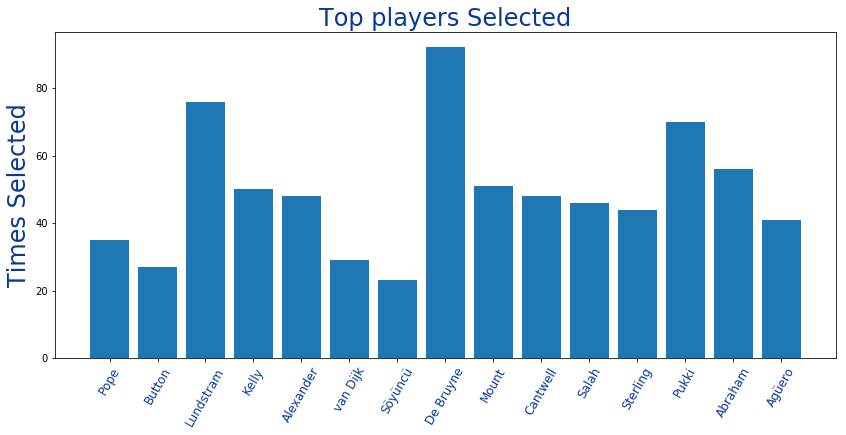

In [164]:
X = [item[0] for item in top_managers_team]
Y = [item[1] for item in top_managers_team]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top players Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.show